In [ ]:
https://www.analyticsvidhya.com/blog/2021/05/bitcoin-price-prediction-using-recurrent-neural-networks-and-lstm/

In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

In [18]:
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure(figsize=(20,3))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()
    
def plot_predictions(Y_test, Y_pred):
    plt.figure(figsize=(20,3))
    plt.plot(Y_test, color = 'red', label = 'Real Price')
    plt.plot(Y_pred, color = 'green', label = 'Predicted Price')
    plt.title('Price Prediction using RNN-LSTM')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def load_data(features = False, data_set_size = 2000):
    df = pd.read_csv('data/EURUSD/M15.csv', index_col=False)
    df = df.drop(columns=['time'])
    df = df[:data_set_size]
    if features == False:
        df = df[['close', 'open', 'high', 'low', 'tick_volume']]
    df = df.reindex(columns=(['close'] + list([a for a in df.columns if a != 'close']) ))
    return df 

def split_test_train(df, split_size =0.8):
    data_training = df[:int(len(df)*split_size)].copy()
    print("Size of Training Data :\n",len(data_training))
    data_test = df[int(len(df)*split_size):].copy()
    print("Size of test Data:\n",len(data_test))
    return data_training, data_test


def create_sliding_window(window_size,  training_data, data_test, scaler):
    X_train = [] 
    Y_train = []
    print("Training Data Shape before sliding Window:\n", training_data.shape[0])
    for i in range(window_size, training_data.shape[0]):
        X_train.append(training_data[i-window_size:i])
        Y_train.append(training_data[i, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    print("Training Data Shape with Sliding Window:\n", X_train.shape)
    part_window_size_days = pd.DataFrame(training_data, columns=data_test.columns).tail(window_size)
    gf= pd.concat([part_window_size_days,data_test], ignore_index=True)
    inputs = scaler.transform(gf)
    X_test = []
    Y_test = []
    for i in range (window_size, inputs.shape[0]):
        X_test.append(inputs[i-window_size:i]) 
        Y_test.append(inputs[i, 0])
    X_test, Y_test= np.array(X_test), np.array(Y_test)
    scale = 1/scaler.scale_[0]
    Y_test = Y_test*scale
    print("Test Data Shape with sliding Window:\n", X_test.shape)
    return X_train, Y_train, X_test, Y_test

def train_model(model, X_train, Y_train, epochs, batch_size, validation_split, learning_rate):
    model.compile(optimizer = Adam(lr=learning_rate), loss = 'mean_squared_error')
    history= model.fit(X_train, Y_train, batch_size = batch_size, epochs= epochs, validation_split=validation_split,shuffle=False, verbose=1 )
    plot_loss(history)
    return model
    
def show_predictions(model, X_test, Y_test, scale):
    Y_pred = model.predict(X_test) 
    Y_pred = Y_pred*scale
    plot_predictions(Y_test, Y_pred)
    return Y_pred

def get_total_directional_accuracy(Y_pred, Y_test):
    t = pd.DataFrame(Y_test, columns=["test"])
    t["pred"] = Y_pred
    t['test_change'] = t.test.pct_change()
    t['pred_change'] = t.pred.pct_change()
    t = t[['test_change', 'pred_change']]
    t = t.dropna()
    t['test_change'] = t['test_change'] > 0 
    t['pred_change'] = t['pred_change'] > 0
    return len(t[t['test_change'] == t['pred_change']]) / len(t)

def get_directional_accuracy_of_small_moves(Y_test, Y_pred):
    t = pd.DataFrame(Y_test, columns=["test"])
    t["pred"] = Y_pred
    t['test_change'] = t.test.pct_change()
    t['pred_change'] = t.pred.pct_change()
    t['abs_pred_change'] = abs(t.pred.pct_change())
    t = t.dropna()
    t['test_change'] = t['test_change'] > 0 
    t['pred_change'] = t['pred_change'] > 0
    t2 = t[t.abs_pred_change < t.abs_pred_change.describe()['25%']]
    return len(t2[t2['test_change'] == t2['pred_change']]) / len(t2)

def get_directional_accuracy_of_large_moves(Y_test, Y_pred):
    t = pd.DataFrame(Y_test, columns=["test"])
    t["pred"] = Y_pred
    t['test_change'] = t.test.pct_change()
    t['pred_change'] = t.pred.pct_change()
    t['abs_pred_change'] = abs(t.pred.pct_change())
    t = t.dropna()
    t['test_change'] = t['test_change'] > 0 
    t['pred_change'] = t['pred_change'] > 0
    t2 = t[t.abs_pred_change > t.abs_pred_change.describe()['75%']]
    return len(t2[t2['test_change'] == t2['pred_change']]) / len(t2)

def initialize_RNN(input_shape):
    #Initialize the RNN
    model = Sequential() 
    model.add(LSTM(units = 100, activation = 'relu', return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.2)) 
    model.add(LSTM(units = window_size, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.3)) 
    model.add(LSTM(units = 120, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.4)) 
    model.add(LSTM(units = 180, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units =1))
    model.summary()
    return model

def test_parameters(window_size, epochs, batch_size, validation_split,train_test_split, ata_set_size, features, learning_rate, path):
    print("-"*50,"DATA PROCESSING","-"*50)
    df = load_data(features = features, data_set_size = data_set_size)
    print("Features:\n",df.columns)
    data_training, data_test = split_test_train(df, train_test_split)
    scaler = MinMaxScaler()
    training_data = scaler.fit_transform(data_training)
    X_train, Y_train, X_test, Y_test = create_sliding_window(window_size,  training_data, data_test, scaler)
    print("-"*50,"MODEL INITIALIZATION","-"*50)
    model = initialize_RNN((X_train.shape[1], X_train.shape[2]))
    print("-"*50,"TRAINING STAGE","-"*50)
    model = train_model(model, X_train, Y_train, epochs, batch_size, validation_split, learning_rate)
    scale = 1/scaler.scale_[0]
    print("-"*50,"RESULTS","-"*50)
    Y_pred = show_predictions(model, X_test, Y_test, scale)
    total_directional_accuracy = get_total_directional_accuracy(Y_pred, Y_test)
    directional_accuracy_of_small_moves = get_directional_accuracy_of_small_moves(Y_test, Y_pred)
    directional_accuracy_of_large_moves = get_directional_accuracy_of_large_moves(Y_test, Y_pred)

    print('Total Directional Accuracy: {:.2f}%'.format(total_directional_accuracy))
    print('Directional Accuracy of small moves: {:.2f}%'.format(directional_accuracy_of_small_moves))
    print('Directional Accuracy of large moves: {:.2f}%'.format(directional_accuracy_of_large_moves))
    
    #res = pd.read_csv("results/results.csv" , index_col=False)
    res = pd.read_csv(path, index_col= False)
    row = [[window_size, epochs, batch_size, validation_split,train_test_split, data_set_size, features,\
           learning_rate, total_directional_accuracy, directional_accuracy_of_small_moves, directional_accuracy_of_large_moves]]
    res = pd.concat([res,pd.DataFrame(row, columns = res.columns)], ignore_index=True)
    res.to_csv(path, index=False)

# Number of Epochs

-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1600
Size of test Data:
 400
Training Data Shape before sliding Window:
 1600
Training Data Shape with Sliding Window:
 (1540, 60, 5)
Test Data Shape with sliding Window:
 (400, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_391 (LSTM)             (None, 60, 100)           42400     
                                                                 
 dropout_390 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_392 (LSTM)             (None, 60, 60)     

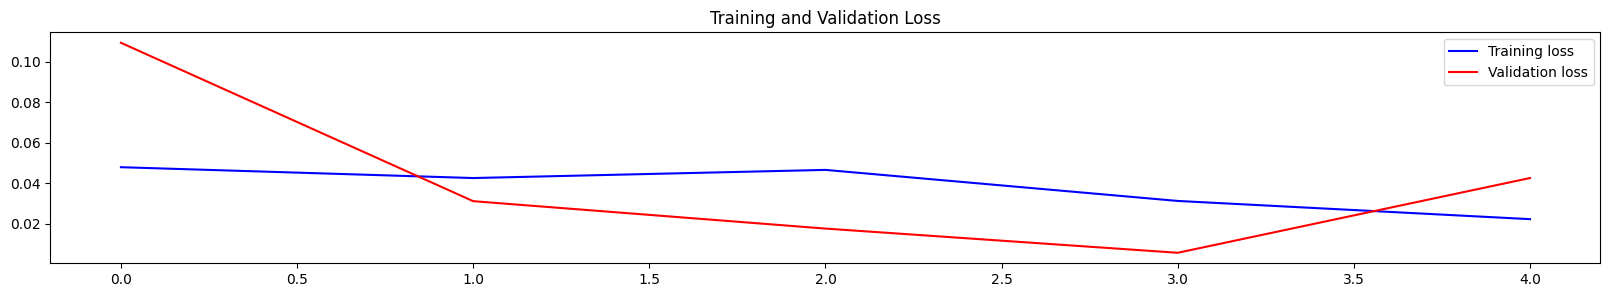

-------------------------------------------------- RESULTS --------------------------------------------------
13/13 [==============================] - 1s 58ms/step


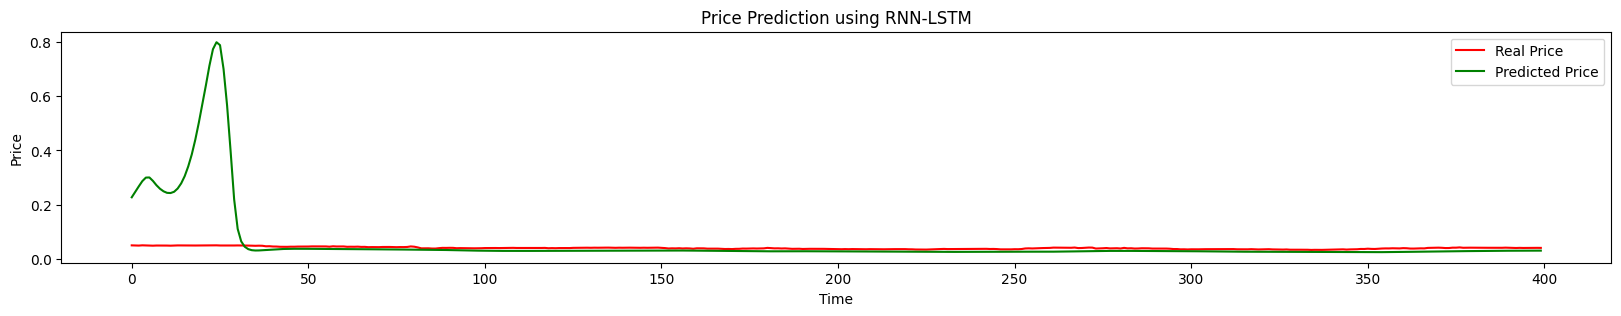

Total Directional Accuracy: 0.53%
Directional Accuracy of small moves: 0.55%
Directional Accuracy of large moves: 0.52%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1600
Size of test Data:
 400
Training Data Shape before sliding Window:
 1600
Training Data Shape with Sliding Window:
 (1540, 60, 5)
Test Data Shape with sliding Window:
 (400, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_395 (LSTM)             (None, 60, 100)           42400     
                                                                 
 dropout_394 (Dropout)       (None, 60, 100)           0    

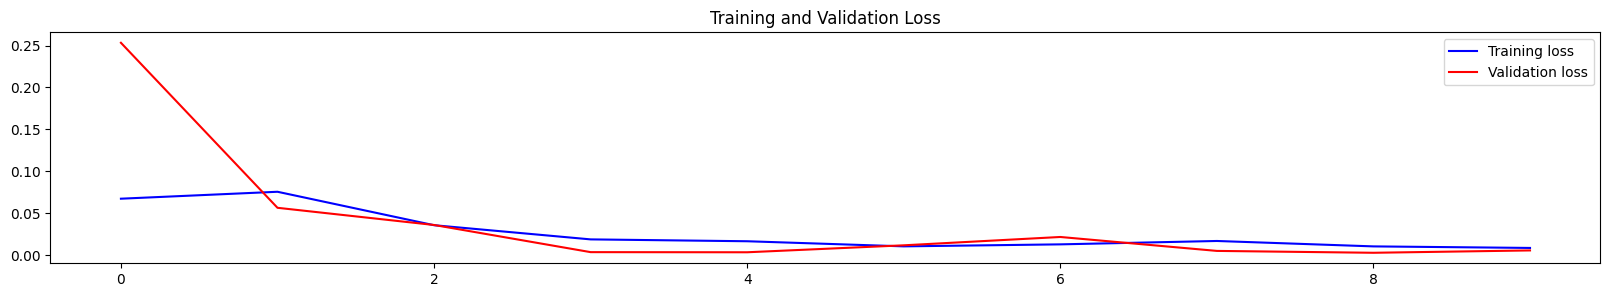

-------------------------------------------------- RESULTS --------------------------------------------------
13/13 [==============================] - 1s 57ms/step


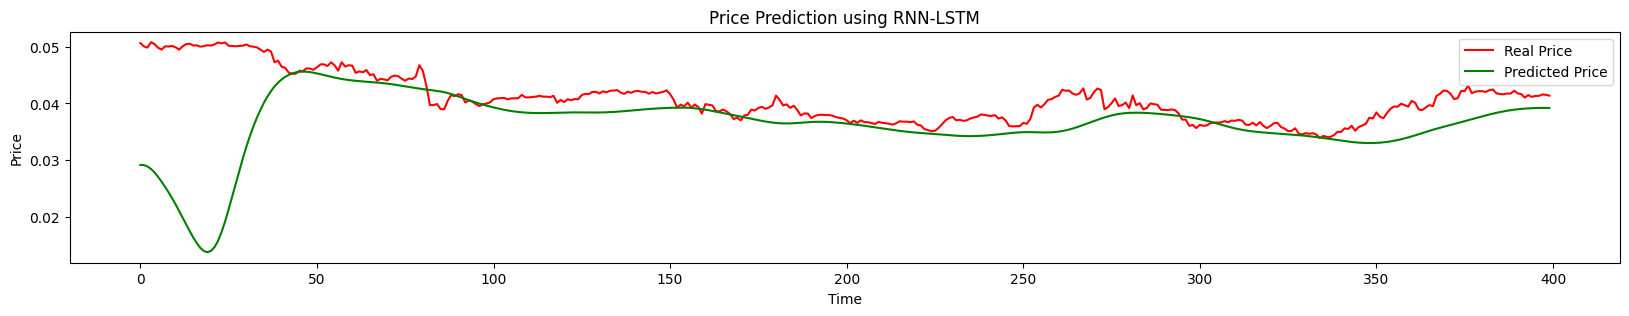

Total Directional Accuracy: 0.50%
Directional Accuracy of small moves: 0.48%
Directional Accuracy of large moves: 0.45%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1600
Size of test Data:
 400
Training Data Shape before sliding Window:
 1600
Training Data Shape with Sliding Window:
 (1540, 60, 5)
Test Data Shape with sliding Window:
 (400, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_399 (LSTM)             (None, 60, 100)           42400     
                                                                 
 dropout_398 (Dropout)       (None, 60, 100)           0    

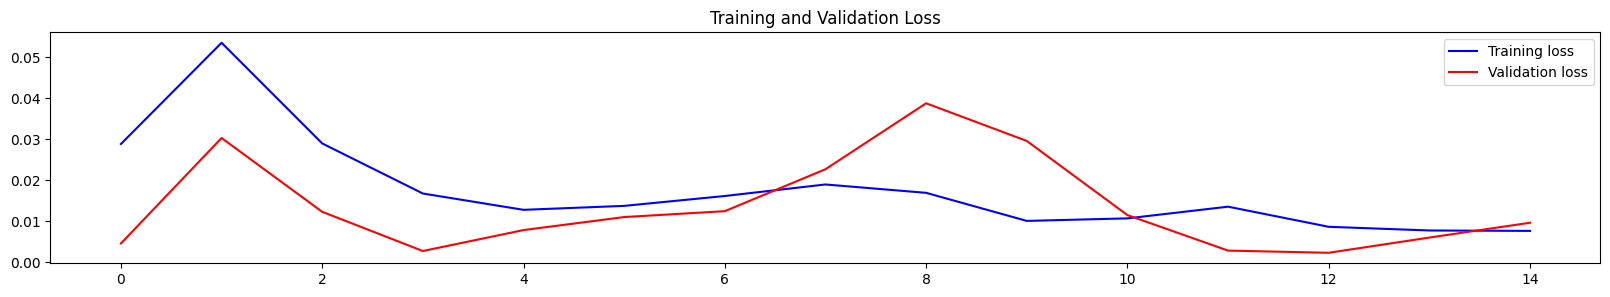

-------------------------------------------------- RESULTS --------------------------------------------------
13/13 [==============================] - 1s 61ms/step


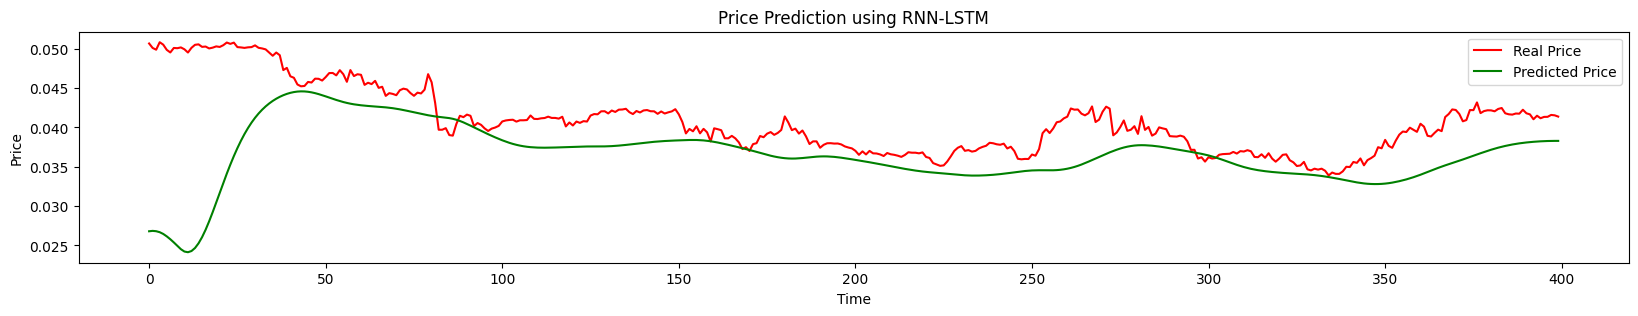

Total Directional Accuracy: 0.52%
Directional Accuracy of small moves: 0.51%
Directional Accuracy of large moves: 0.47%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1600
Size of test Data:
 400
Training Data Shape before sliding Window:
 1600
Training Data Shape with Sliding Window:
 (1540, 60, 5)
Test Data Shape with sliding Window:
 (400, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_403 (LSTM)             (None, 60, 100)           42400     
                                                                 
 dropout_402 (Dropout)       (None, 60, 100)           0    

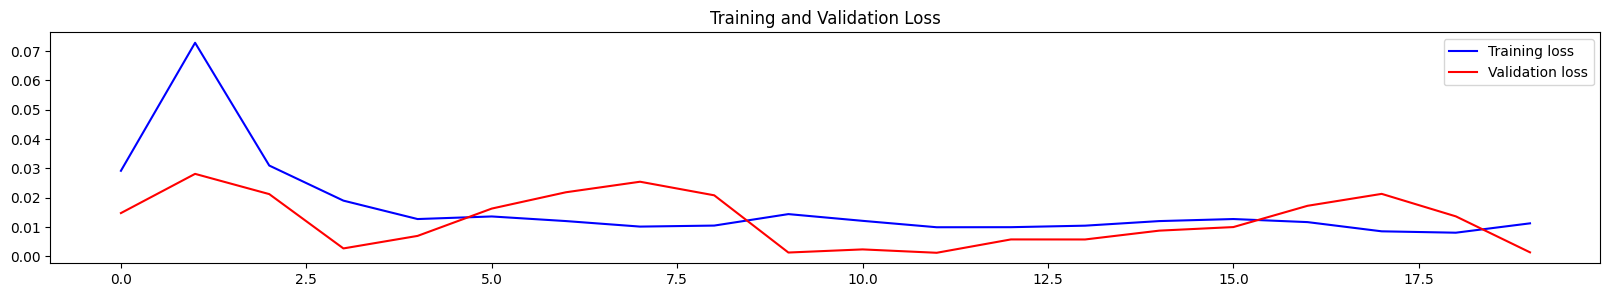

-------------------------------------------------- RESULTS --------------------------------------------------
13/13 [==============================] - 1s 58ms/step


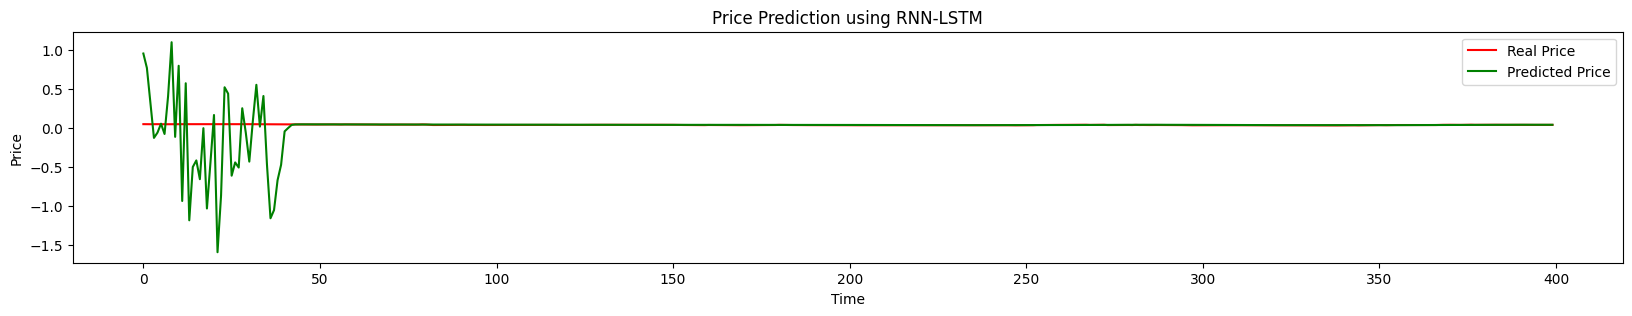

Total Directional Accuracy: 0.54%
Directional Accuracy of small moves: 0.58%
Directional Accuracy of large moves: 0.48%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1600
Size of test Data:
 400
Training Data Shape before sliding Window:
 1600
Training Data Shape with Sliding Window:
 (1540, 60, 5)
Test Data Shape with sliding Window:
 (400, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_407 (LSTM)             (None, 60, 100)           42400     
                                                                 
 dropout_406 (Dropout)       (None, 60, 100)           0    

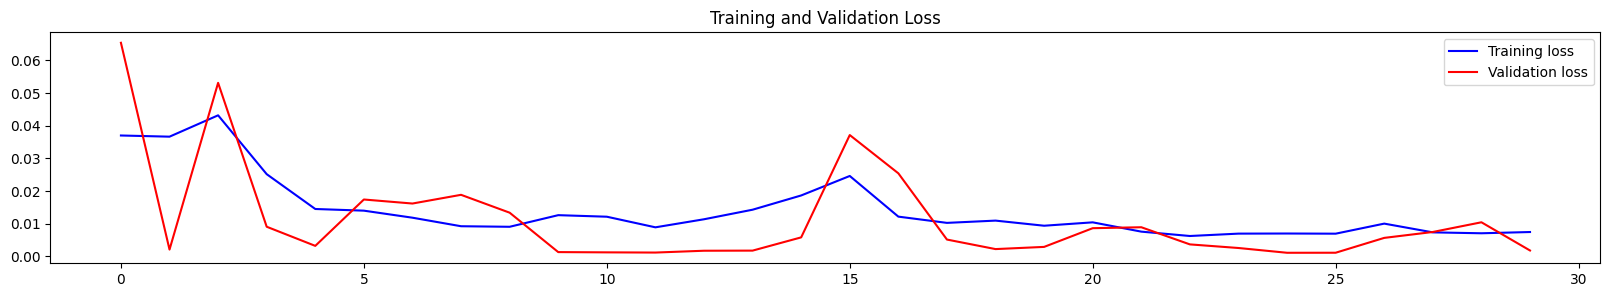

-------------------------------------------------- RESULTS --------------------------------------------------
13/13 [==============================] - 1s 57ms/step


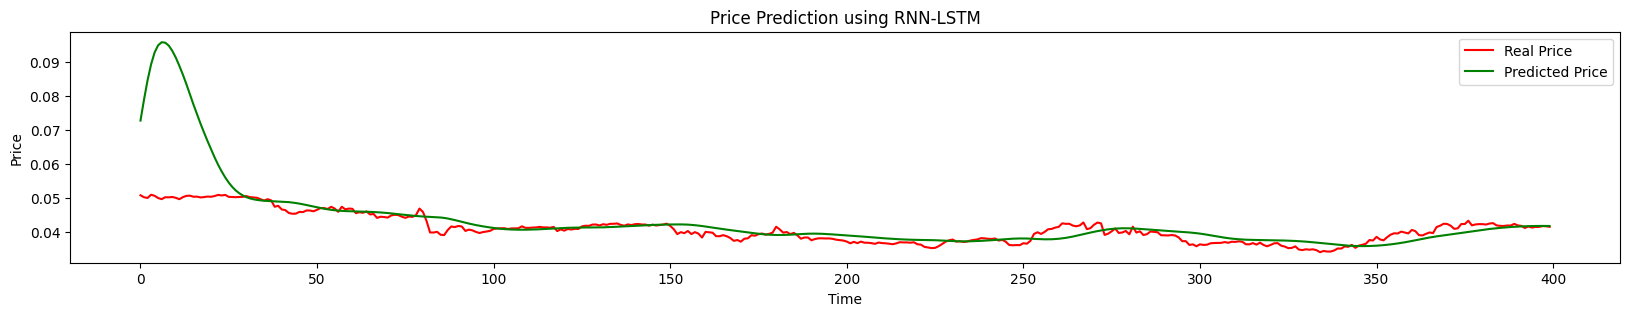

Total Directional Accuracy: 0.53%
Directional Accuracy of small moves: 0.58%
Directional Accuracy of large moves: 0.47%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1600
Size of test Data:
 400
Training Data Shape before sliding Window:
 1600
Training Data Shape with Sliding Window:
 (1540, 60, 5)
Test Data Shape with sliding Window:
 (400, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_411 (LSTM)             (None, 60, 100)           42400     
                                                                 
 dropout_410 (Dropout)       (None, 60, 100)           0    

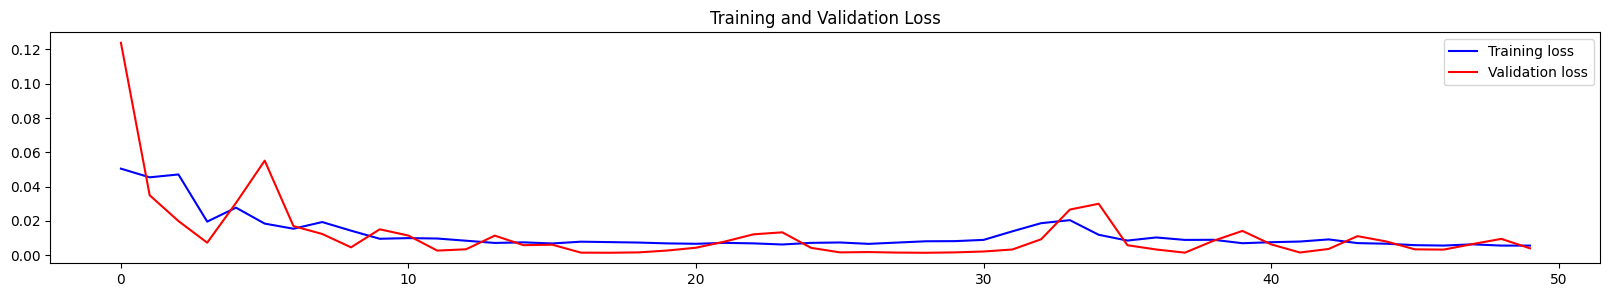

-------------------------------------------------- RESULTS --------------------------------------------------
13/13 [==============================] - 1s 57ms/step


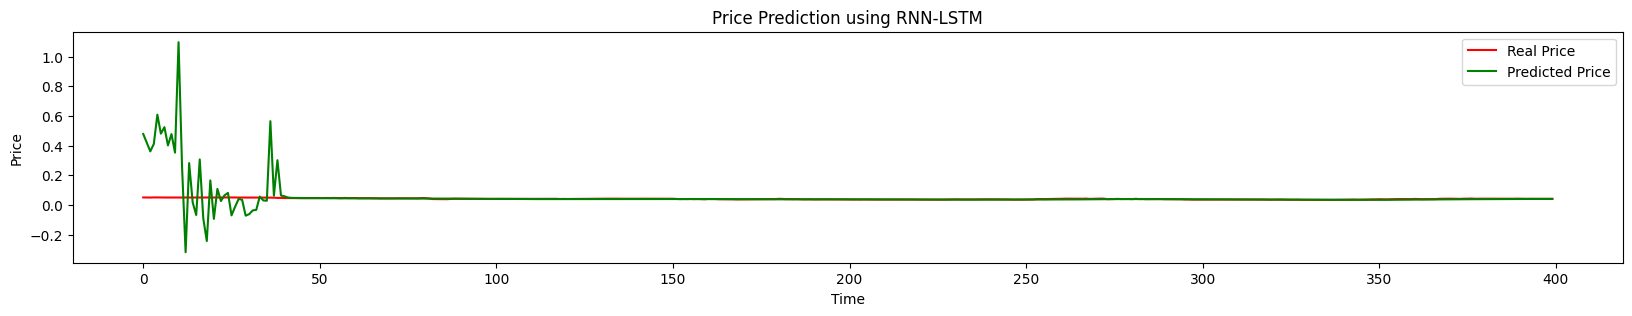

Total Directional Accuracy: 0.53%
Directional Accuracy of small moves: 0.52%
Directional Accuracy of large moves: 0.50%


In [41]:
window_size = 60
epochs = 10
batch_size =100
validation_split=0.1
train_test_split = 0.8
data_set_size = 2000
features = False
learning_rate = 0.01

path = 'results/results_{}.csv'.format("epochs")
res = pd.DataFrame(columns=['window_size', 'epochs', 'batch_size', 'validation_split', 'train_test_split', 'data_set_size', 'features',\
       'total_directional_accuracy', 'directional_accuracy_of_small_moves', 'directional_accuracy_of_large_moves'])
res.to_csv(path, index=False)

for epochs in [5,10,15,20,30,50]:
    test_parameters(window_size, epochs, batch_size, validation_split,train_test_split, data_set_size, features, learning_rate, path)


# Batch Size

-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1760
Size of test Data:
 440
Training Data Shape before sliding Window:
 1760
Training Data Shape with Sliding Window:
 (1700, 60, 5)
Test Data Shape with sliding Window:
 (440, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_415 (LSTM)             (None, 60, 100)           42400     
                                                                 
 dropout_414 (Dropout)       (None, 60, 100)           0         
                                                                 
 lstm_416 (LSTM)             (None, 60, 60)     

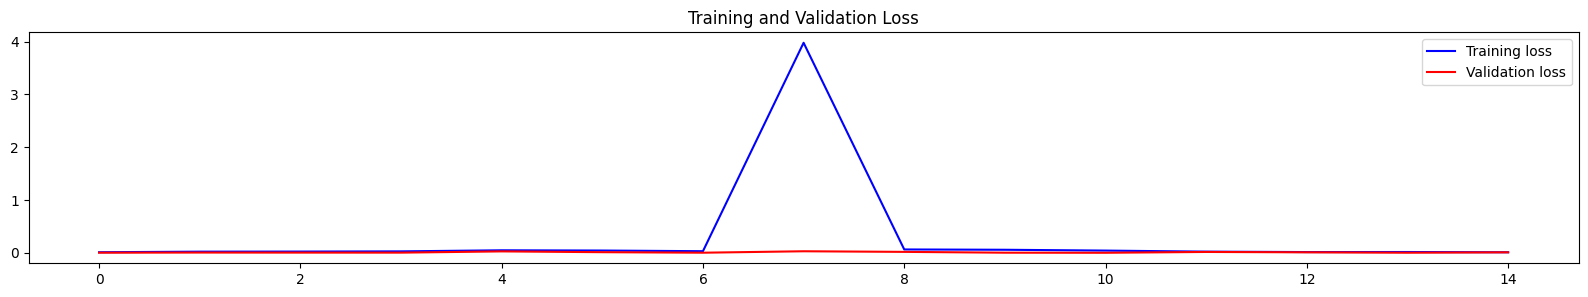

-------------------------------------------------- RESULTS --------------------------------------------------
14/14 [==============================] - 1s 57ms/step


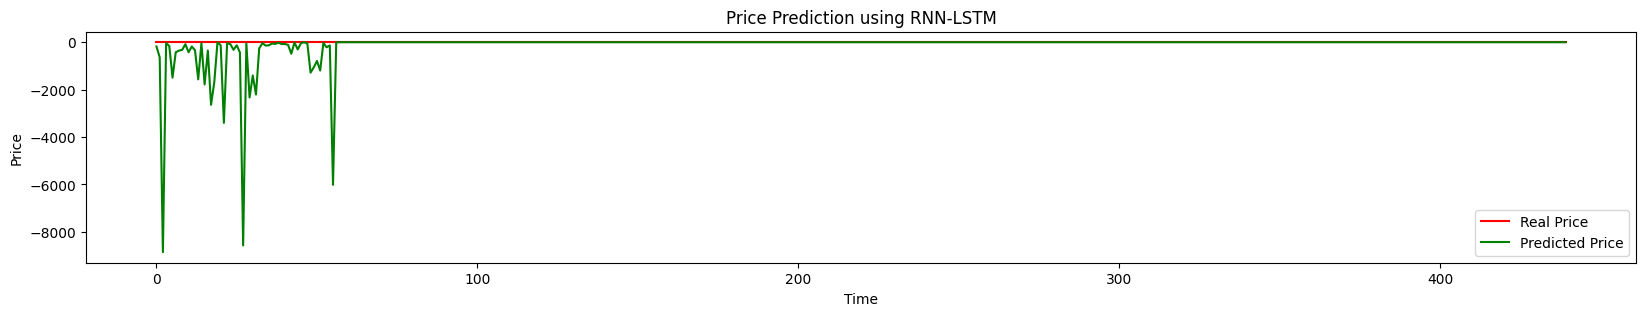

Total Directional Accuracy: 0.48%
Directional Accuracy of small moves: 0.54%
Directional Accuracy of large moves: 0.47%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1760
Size of test Data:
 440
Training Data Shape before sliding Window:
 1760
Training Data Shape with Sliding Window:
 (1700, 60, 5)
Test Data Shape with sliding Window:
 (440, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_419 (LSTM)             (None, 60, 100)           42400     
                                                                 
 dropout_418 (Dropout)       (None, 60, 100)           0    

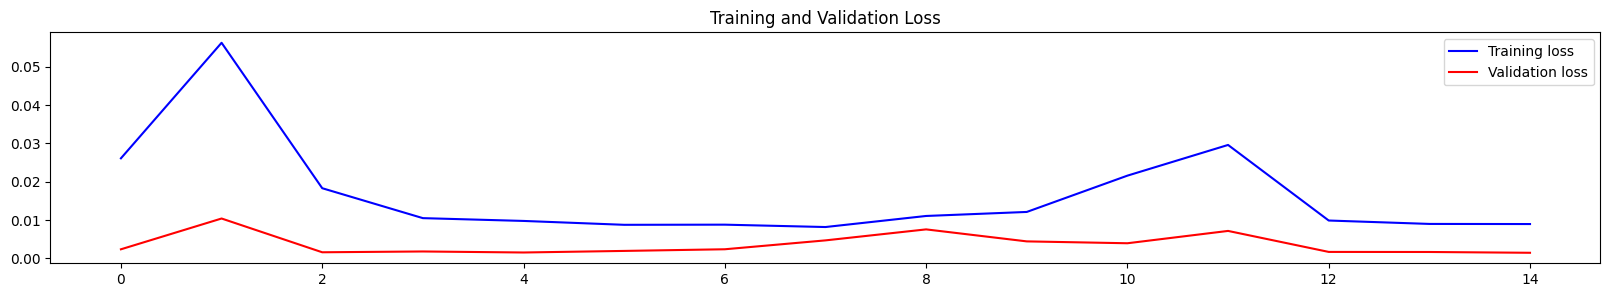

-------------------------------------------------- RESULTS --------------------------------------------------
14/14 [==============================] - 1s 59ms/step


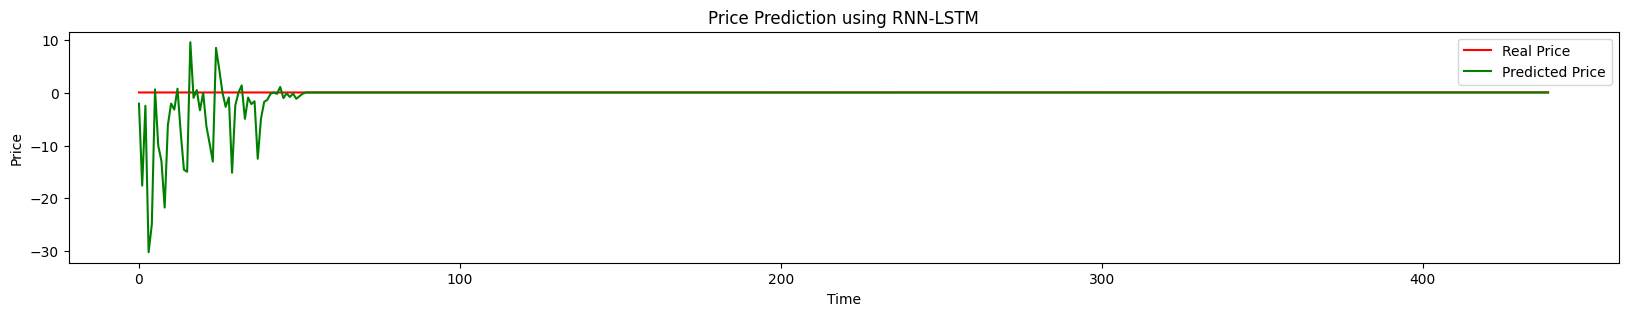

Total Directional Accuracy: 0.51%
Directional Accuracy of small moves: 0.59%
Directional Accuracy of large moves: 0.49%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1760
Size of test Data:
 440
Training Data Shape before sliding Window:
 1760
Training Data Shape with Sliding Window:
 (1700, 60, 5)
Test Data Shape with sliding Window:
 (440, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_423 (LSTM)             (None, 60, 100)           42400     
                                                                 
 dropout_422 (Dropout)       (None, 60, 100)           0    

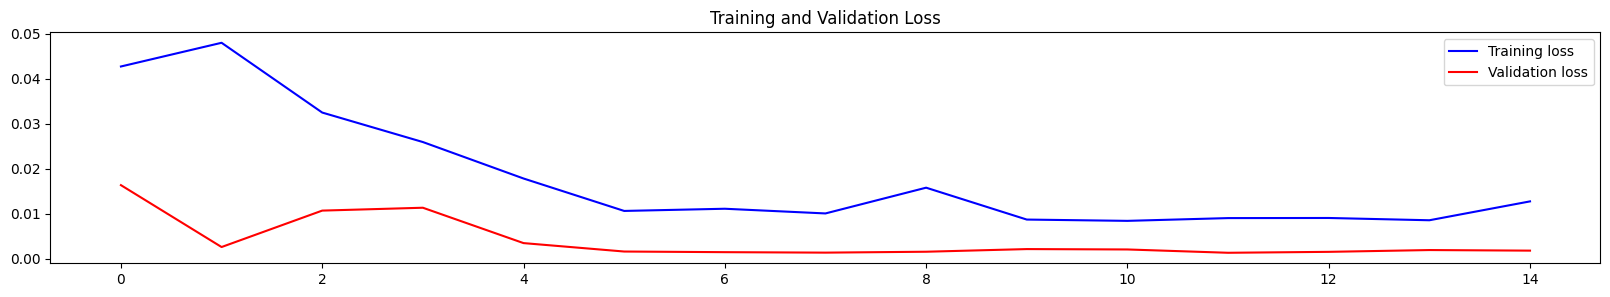

-------------------------------------------------- RESULTS --------------------------------------------------
14/14 [==============================] - 1s 60ms/step


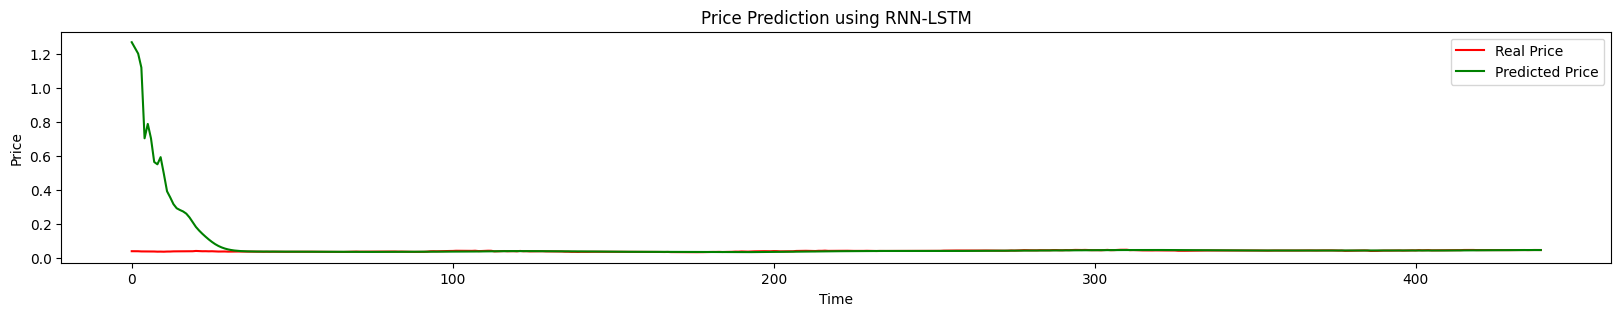

Total Directional Accuracy: 0.51%
Directional Accuracy of small moves: 0.52%
Directional Accuracy of large moves: 0.55%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1760
Size of test Data:
 440
Training Data Shape before sliding Window:
 1760
Training Data Shape with Sliding Window:
 (1700, 60, 5)
Test Data Shape with sliding Window:
 (440, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_427 (LSTM)             (None, 60, 100)           42400     
                                                                 
 dropout_426 (Dropout)       (None, 60, 100)           0    

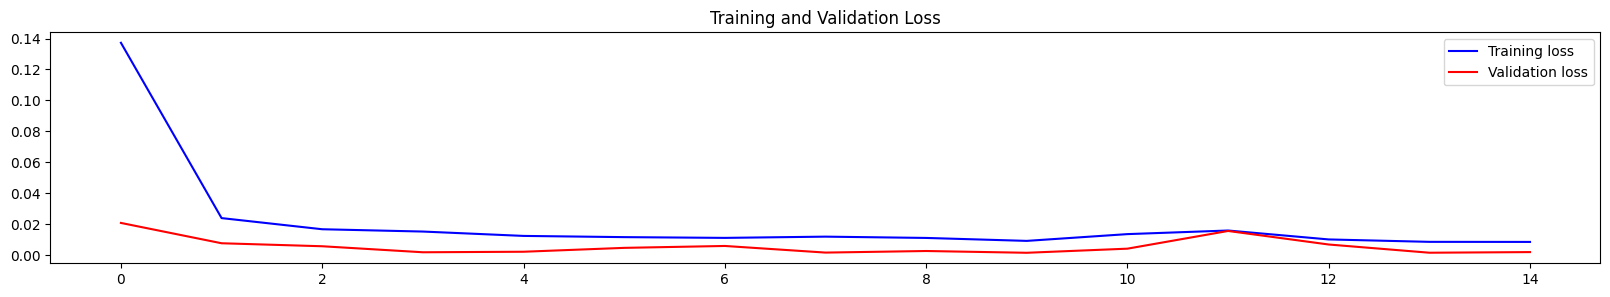

-------------------------------------------------- RESULTS --------------------------------------------------
14/14 [==============================] - 1s 65ms/step


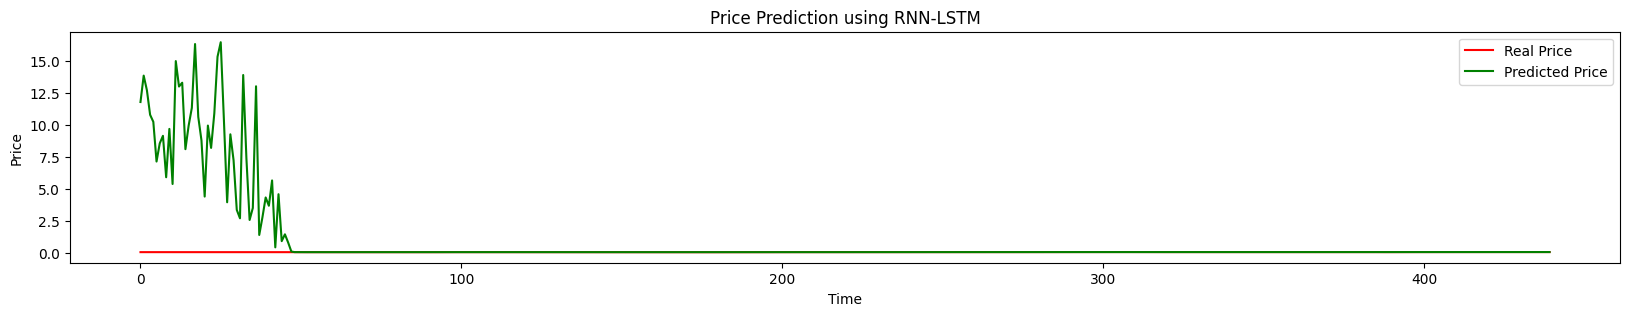

Total Directional Accuracy: 0.49%
Directional Accuracy of small moves: 0.47%
Directional Accuracy of large moves: 0.52%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1760
Size of test Data:
 440
Training Data Shape before sliding Window:
 1760
Training Data Shape with Sliding Window:
 (1700, 60, 5)
Test Data Shape with sliding Window:
 (440, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_431 (LSTM)             (None, 60, 100)           42400     
                                                                 
 dropout_430 (Dropout)       (None, 60, 100)           0    

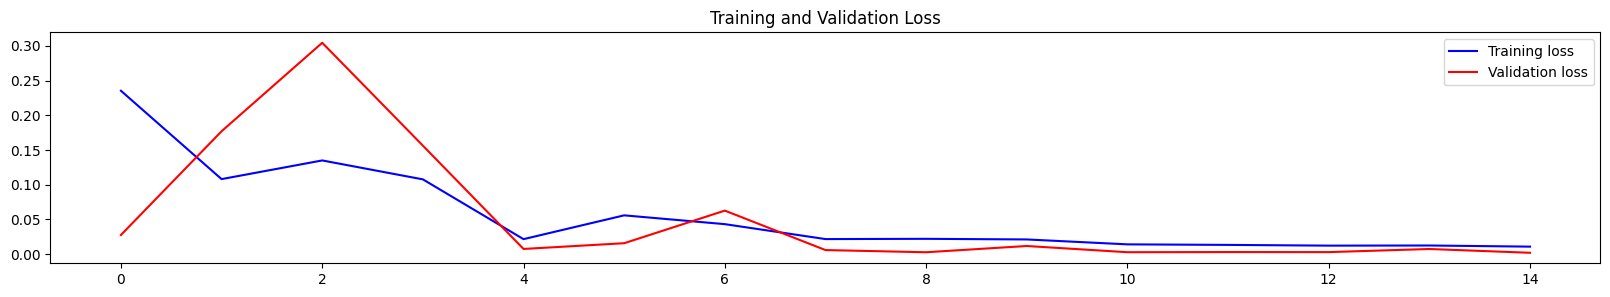

-------------------------------------------------- RESULTS --------------------------------------------------
14/14 [==============================] - 1s 62ms/step


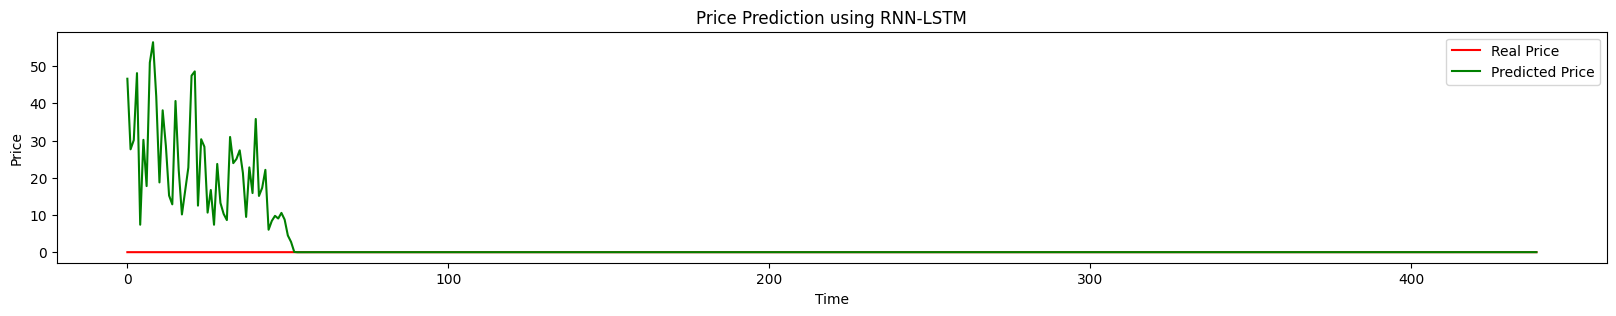

Total Directional Accuracy: 0.53%
Directional Accuracy of small moves: 0.52%
Directional Accuracy of large moves: 0.54%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1760
Size of test Data:
 440
Training Data Shape before sliding Window:
 1760
Training Data Shape with Sliding Window:
 (1700, 60, 5)
Test Data Shape with sliding Window:
 (440, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_435 (LSTM)             (None, 60, 100)           42400     
                                                                 
 dropout_434 (Dropout)       (None, 60, 100)           0    

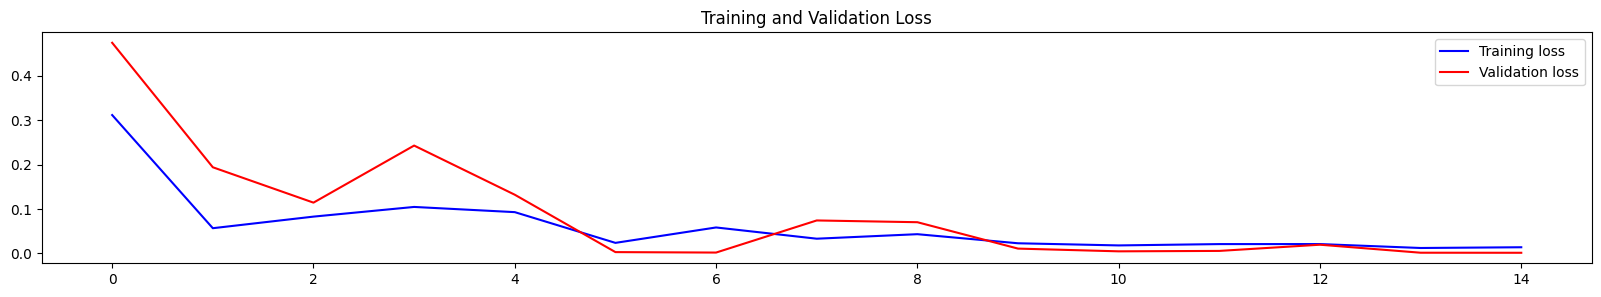

-------------------------------------------------- RESULTS --------------------------------------------------
14/14 [==============================] - 1s 58ms/step


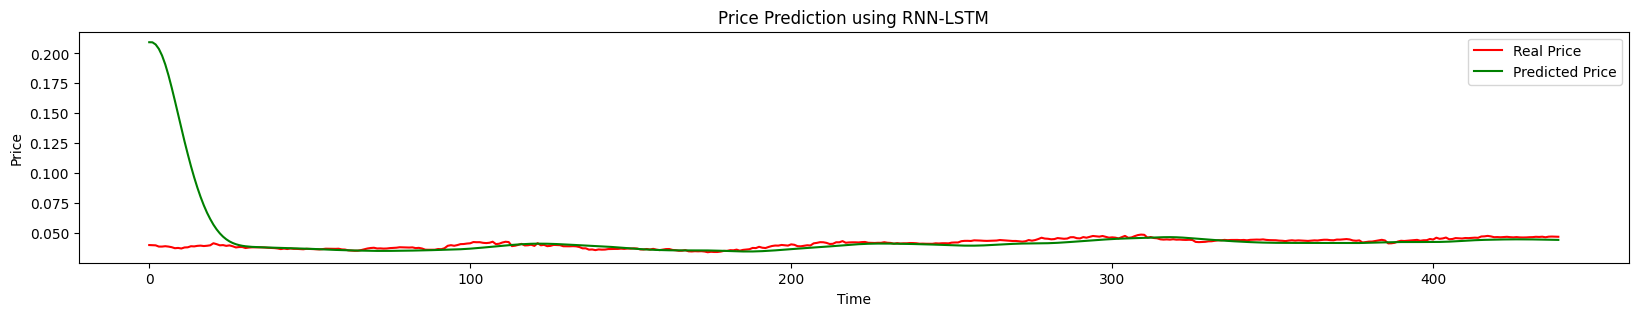

Total Directional Accuracy: 0.53%
Directional Accuracy of small moves: 0.55%
Directional Accuracy of large moves: 0.53%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1760
Size of test Data:
 440
Training Data Shape before sliding Window:
 1760
Training Data Shape with Sliding Window:
 (1700, 60, 5)
Test Data Shape with sliding Window:
 (440, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_439 (LSTM)             (None, 60, 100)           42400     
                                                                 
 dropout_438 (Dropout)       (None, 60, 100)           0    

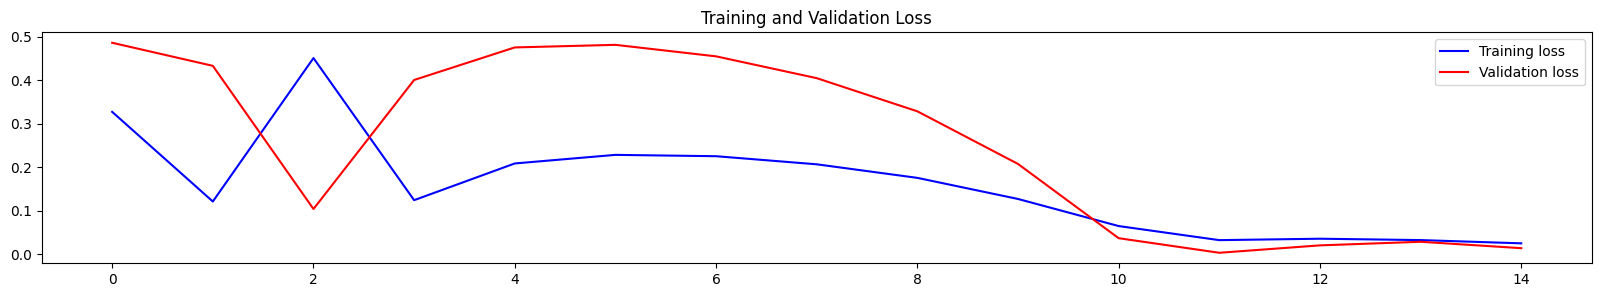

-------------------------------------------------- RESULTS --------------------------------------------------
14/14 [==============================] - 1s 60ms/step


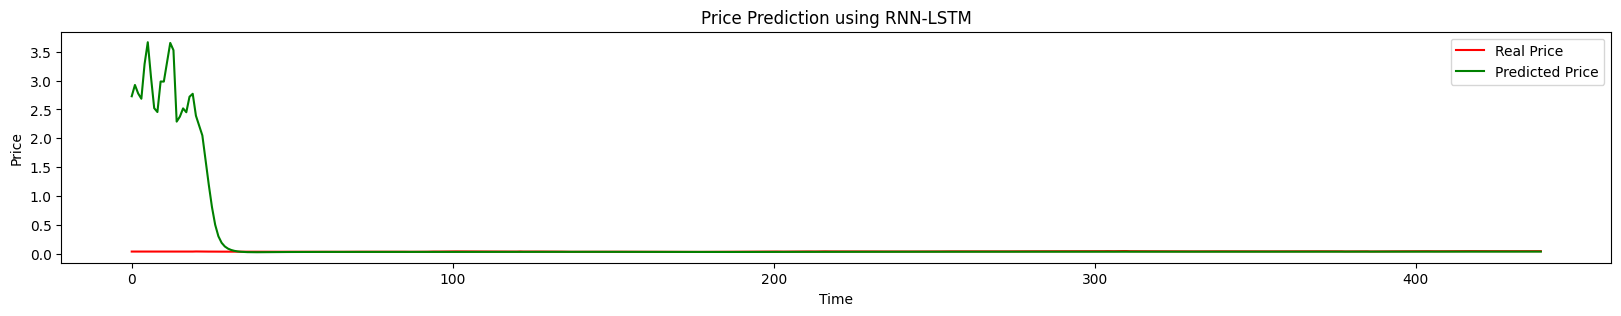

Total Directional Accuracy: 0.52%
Directional Accuracy of small moves: 0.56%
Directional Accuracy of large moves: 0.51%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1760
Size of test Data:
 440
Training Data Shape before sliding Window:
 1760
Training Data Shape with Sliding Window:
 (1700, 60, 5)
Test Data Shape with sliding Window:
 (440, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_443 (LSTM)             (None, 60, 100)           42400     
                                                                 
 dropout_442 (Dropout)       (None, 60, 100)           0    

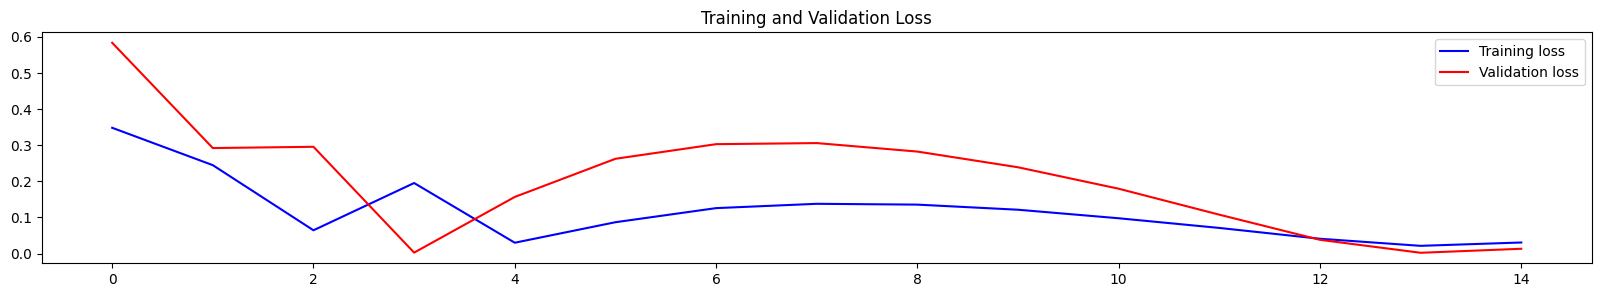

-------------------------------------------------- RESULTS --------------------------------------------------
14/14 [==============================] - 1s 60ms/step


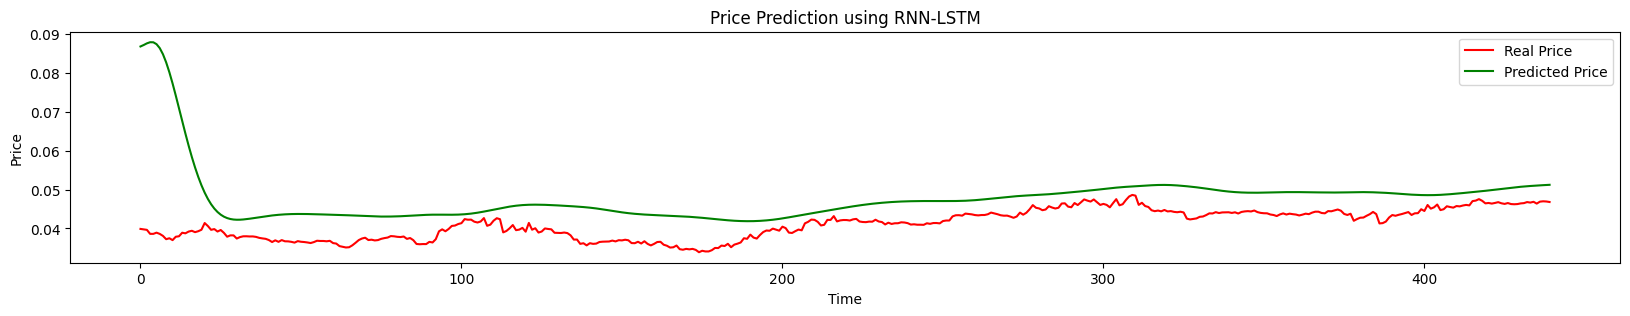

Total Directional Accuracy: 0.47%
Directional Accuracy of small moves: 0.46%
Directional Accuracy of large moves: 0.44%


In [42]:
window_size = 60
epochs = 15
batch_size =100
validation_split=0.1
train_test_split = 0.8
data_set_size = 2200
features = False
learning_rate = 0.01

path = 'results/results_{}.csv'.format("batch_size")
res = pd.DataFrame(columns=['window_size', 'epochs', 'batch_size', 'validation_split', 'train_test_split', 'data_set_size', 'features',\
       'total_directional_accuracy', 'directional_accuracy_of_small_moves', 'directional_accuracy_of_large_moves'])
res.to_csv(path, index=False)

for batch_size in [10,50,100,200,300,400,500,1000]:
    test_parameters(window_size, epochs, batch_size, validation_split,train_test_split, data_set_size, features, learning_rate, path)

# Window Size

-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1760
Size of test Data:
 440
Training Data Shape before sliding Window:
 1760
Training Data Shape with Sliding Window:
 (1755, 5, 5)
Test Data Shape with sliding Window:
 (440, 5, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------


2022-12-18 15:38:56.526777: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-18 15:38:56.527591: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-18 15:38:56.527621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-12-18 15:38:56.528921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 100)            42400     
                                                                 
 dropout (Dropout)           (None, 5, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 5)              2120      
                                                                 
 dropout_1 (Dropout)         (None, 5, 5)              0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 120)            60480     
                                                                 
 dropout_2 (Dropout)         (None, 5, 120)            0         
                                                                 
 lstm_3 (LSTM)               (None, 180)               2

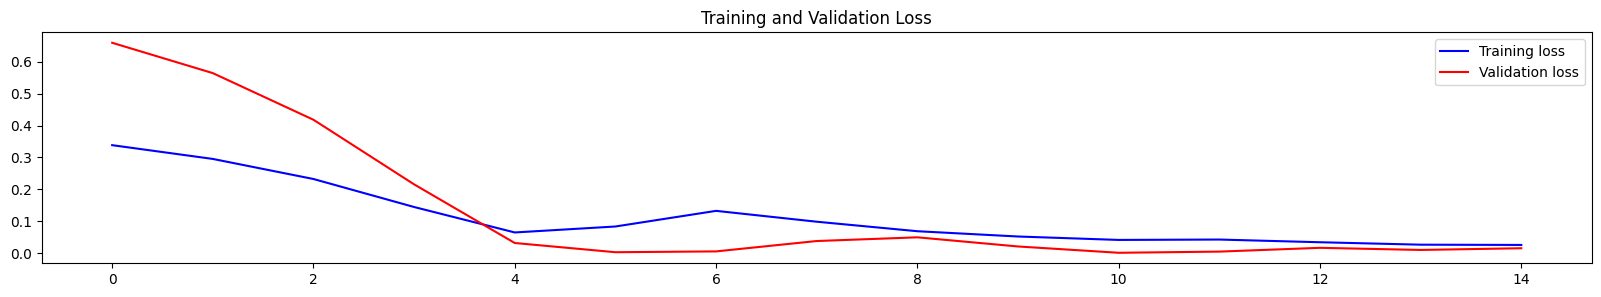

-------------------------------------------------- RESULTS --------------------------------------------------
14/14 [==============================] - 1s 6ms/step


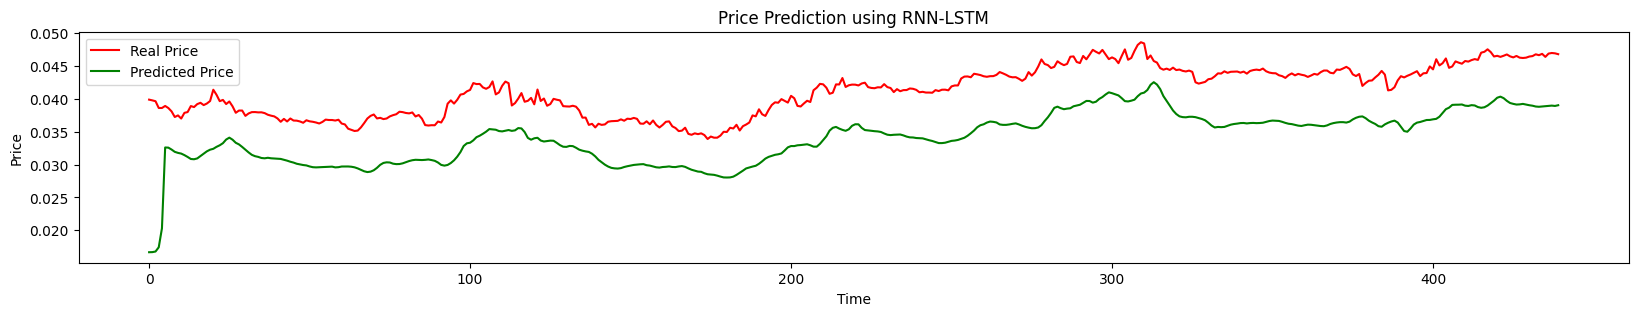

Total Directional Accuracy: 0.51%
Directional Accuracy of small moves: 0.58%
Directional Accuracy of large moves: 0.49%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1760
Size of test Data:
 440
Training Data Shape before sliding Window:
 1760
Training Data Shape with Sliding Window:
 (1750, 10, 5)
Test Data Shape with sliding Window:
 (440, 10, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 100)           42400     
                                                                 
 dropout_4 (Dropout)         (None, 10, 100)           0     

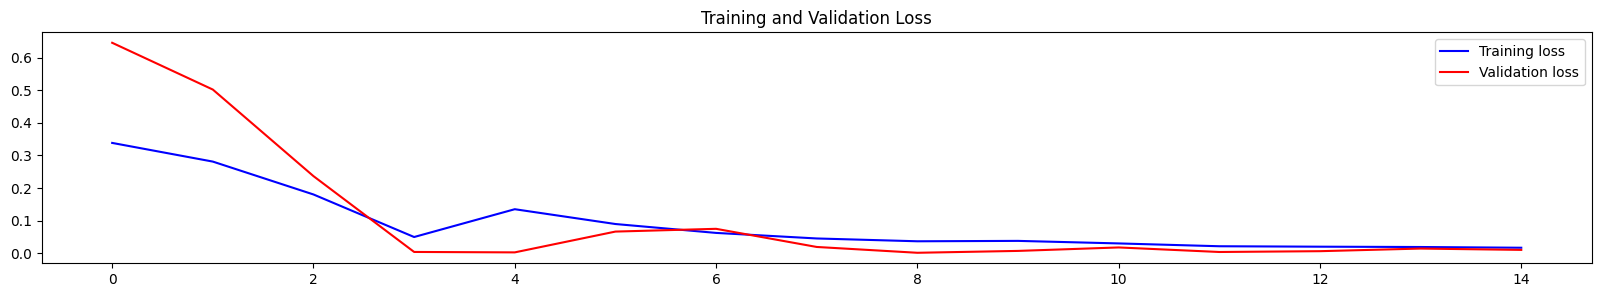

-------------------------------------------------- RESULTS --------------------------------------------------
14/14 [==============================] - 1s 11ms/step


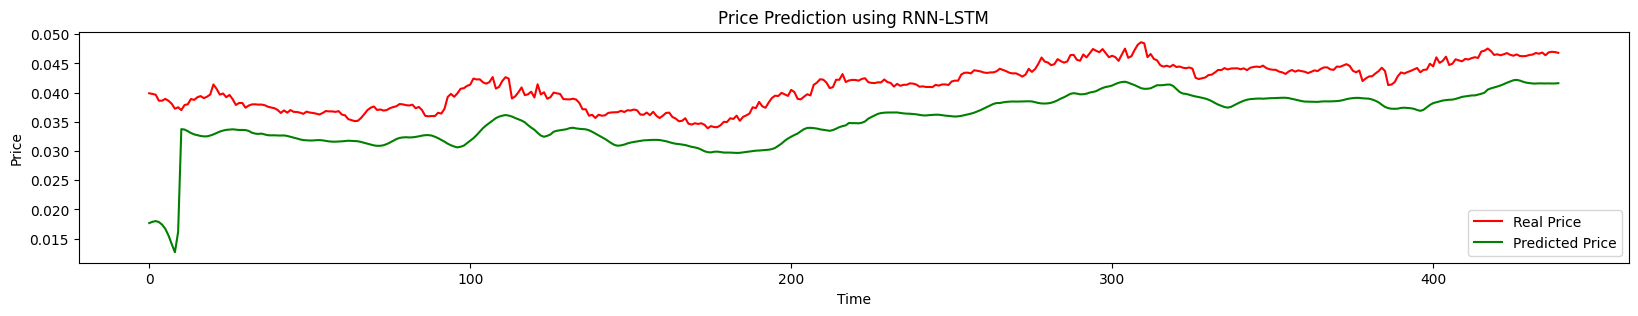

Total Directional Accuracy: 0.47%
Directional Accuracy of small moves: 0.43%
Directional Accuracy of large moves: 0.47%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1760
Size of test Data:
 440
Training Data Shape before sliding Window:
 1760
Training Data Shape with Sliding Window:
 (1740, 20, 5)
Test Data Shape with sliding Window:
 (440, 20, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 20, 100)           42400     
                                                                 
 dropout_8 (Dropout)         (None, 20, 100)           0     

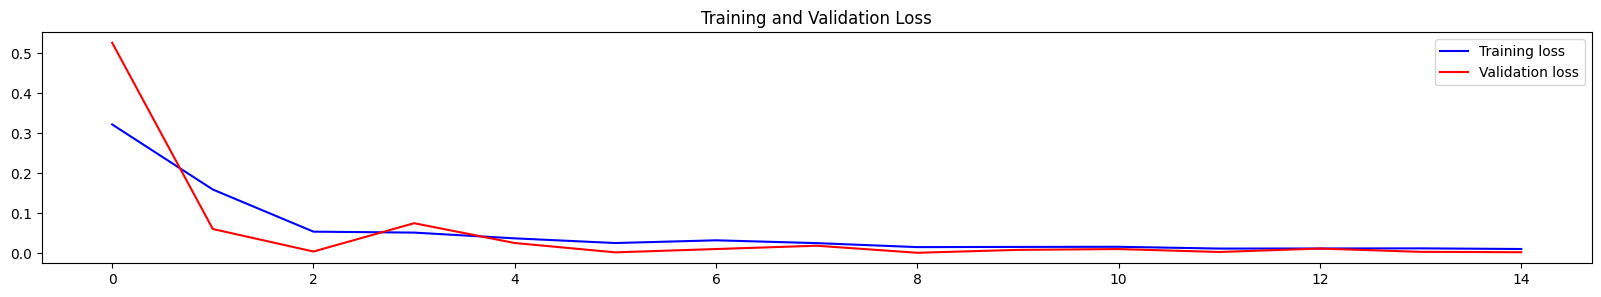

-------------------------------------------------- RESULTS --------------------------------------------------
14/14 [==============================] - 1s 19ms/step


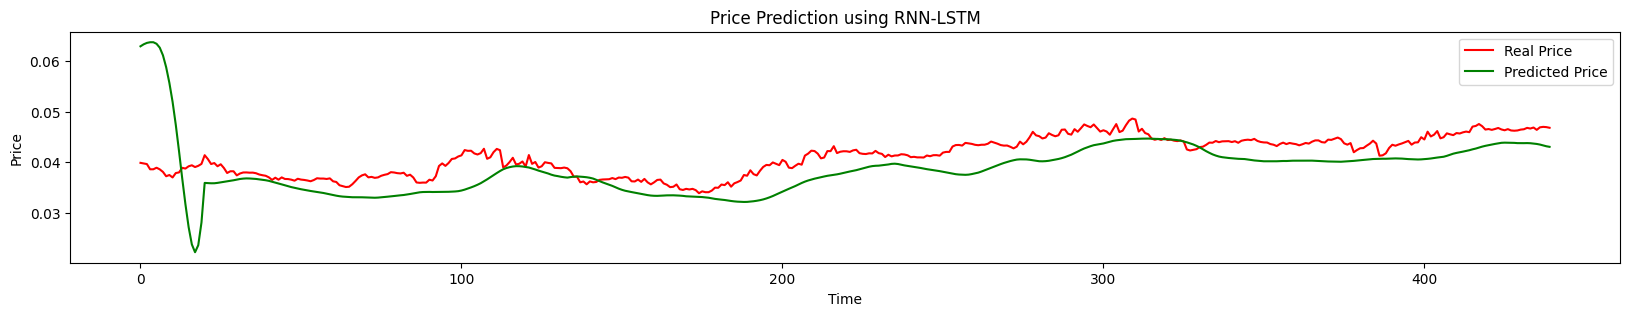

Total Directional Accuracy: 0.53%
Directional Accuracy of small moves: 0.53%
Directional Accuracy of large moves: 0.48%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1760
Size of test Data:
 440
Training Data Shape before sliding Window:
 1760
Training Data Shape with Sliding Window:
 (1730, 30, 5)
Test Data Shape with sliding Window:
 (440, 30, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 100)           42400     
                                                                 
 dropout_12 (Dropout)        (None, 30, 100)           0     

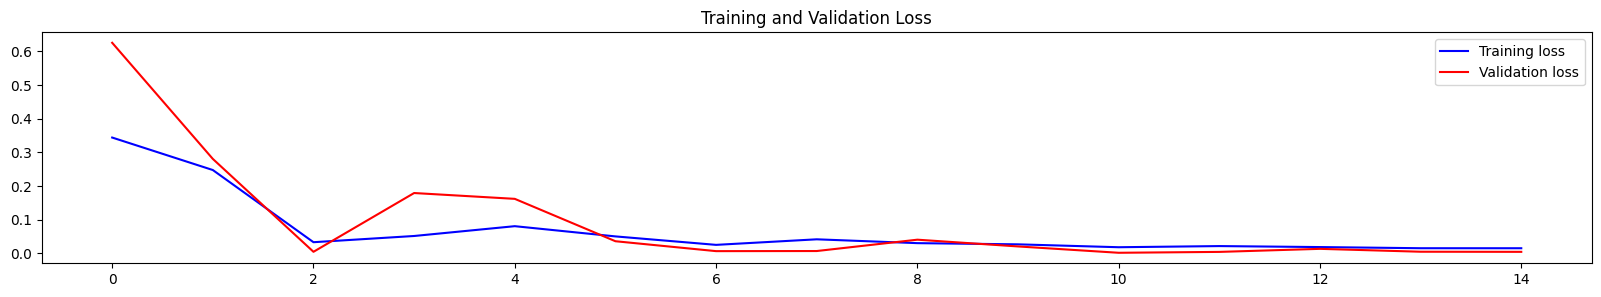

-------------------------------------------------- RESULTS --------------------------------------------------
14/14 [==============================] - 1s 31ms/step


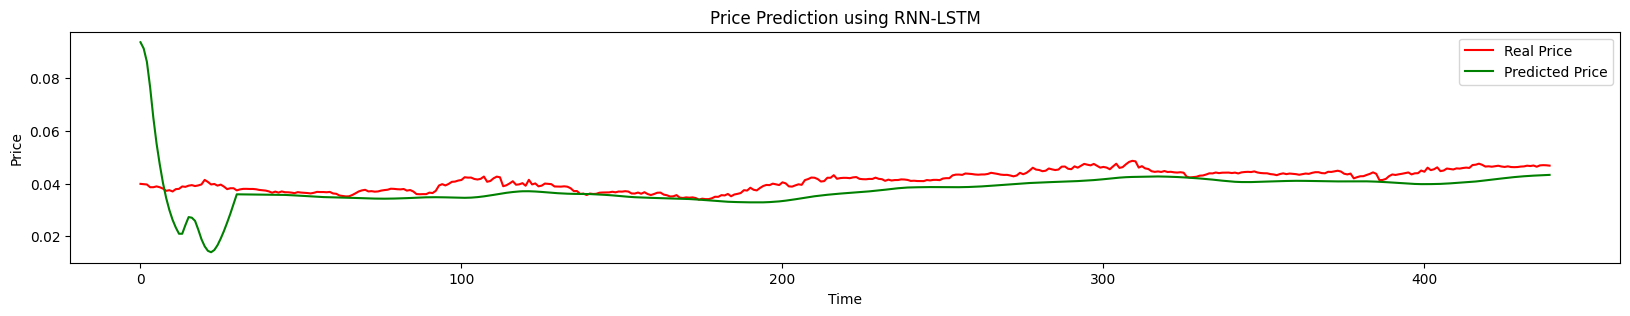

Total Directional Accuracy: 0.47%
Directional Accuracy of small moves: 0.46%
Directional Accuracy of large moves: 0.49%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1760
Size of test Data:
 440
Training Data Shape before sliding Window:
 1760
Training Data Shape with Sliding Window:
 (1700, 60, 5)
Test Data Shape with sliding Window:
 (440, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 60, 100)           42400     
                                                                 
 dropout_16 (Dropout)        (None, 60, 100)           0     

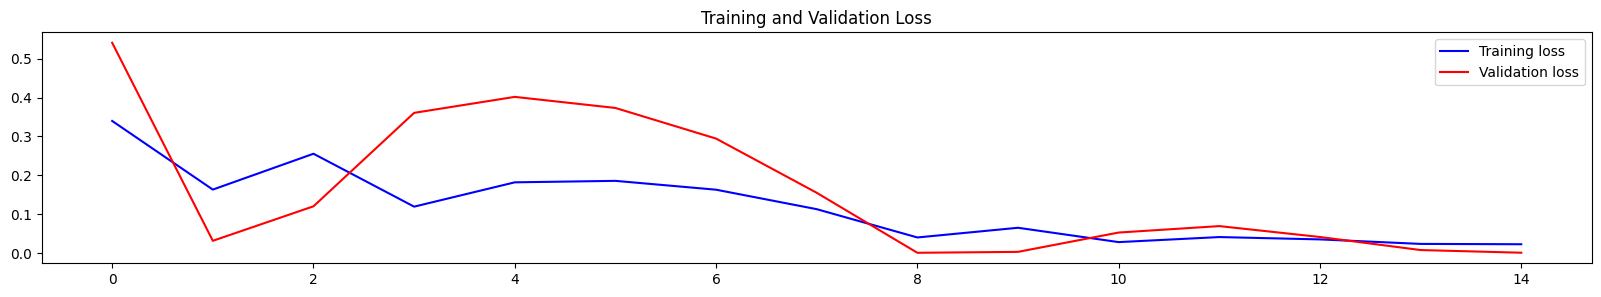

-------------------------------------------------- RESULTS --------------------------------------------------
14/14 [==============================] - 1s 57ms/step


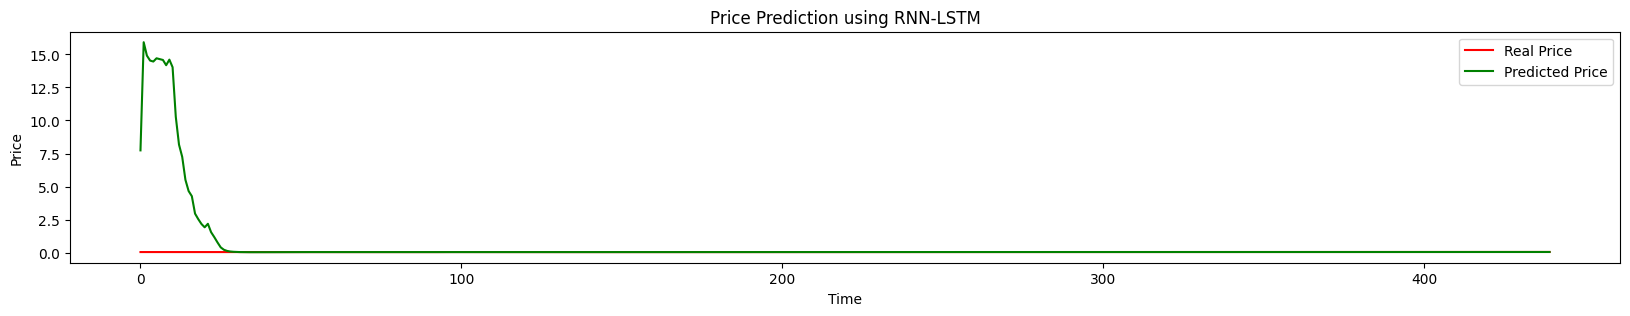

Total Directional Accuracy: 0.47%
Directional Accuracy of small moves: 0.43%
Directional Accuracy of large moves: 0.45%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1760
Size of test Data:
 440
Training Data Shape before sliding Window:
 1760
Training Data Shape with Sliding Window:
 (1660, 100, 5)
Test Data Shape with sliding Window:
 (440, 100, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 100, 100)          42400     
                                                                 
 dropout_20 (Dropout)        (None, 100, 100)          0   

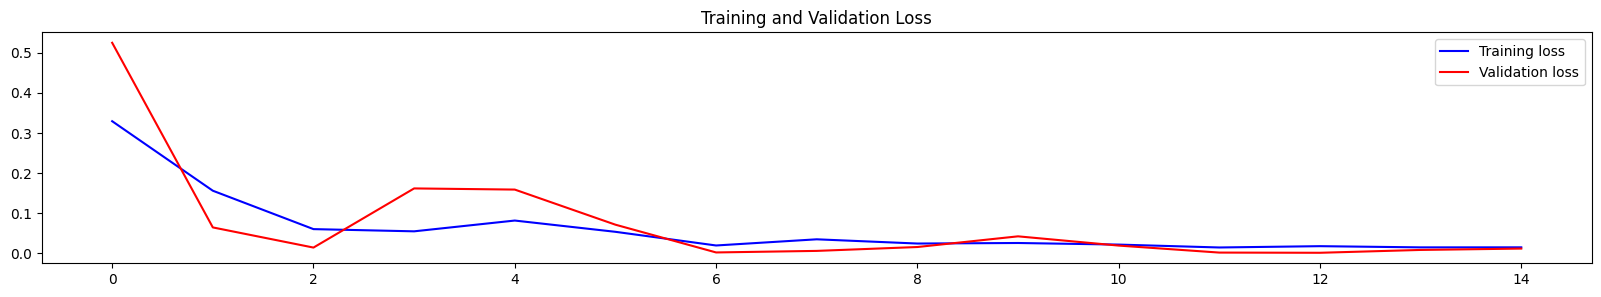

-------------------------------------------------- RESULTS --------------------------------------------------
14/14 [==============================] - 2s 96ms/step


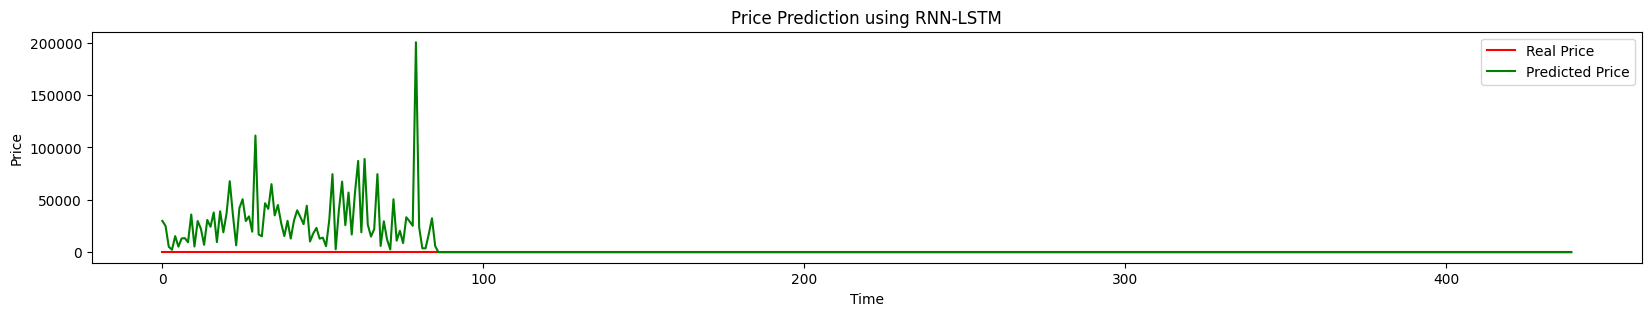

Total Directional Accuracy: 0.50%
Directional Accuracy of small moves: 0.54%
Directional Accuracy of large moves: 0.48%


In [3]:
window_size = 60
epochs = 15
batch_size =500
validation_split=0.1
train_test_split = 0.8
data_set_size = 2200
features = False
learning_rate = 0.01

path = 'results/results_{}.csv'.format("window_size")
res = pd.DataFrame(columns=['window_size', 'epochs', 'batch_size', 'validation_split', 'train_test_split', 'data_set_size', 'features',\
       'total_directional_accuracy', 'directional_accuracy_of_small_moves', 'directional_accuracy_of_large_moves'])
res.to_csv(path, index=False)

for window_size in [5,10,20,30,60,100]:
    test_parameters(window_size, epochs, batch_size, validation_split,train_test_split, data_set_size, features, learning_rate, path)

# Dataset Size

-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 800
Size of test Data:
 200
Training Data Shape before sliding Window:
 800
Training Data Shape with Sliding Window:
 (740, 60, 5)
Test Data Shape with sliding Window:
 (200, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 60, 100)           42400     
                                                                 
 dropout_24 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_25 (LSTM)              (None, 60, 60)         

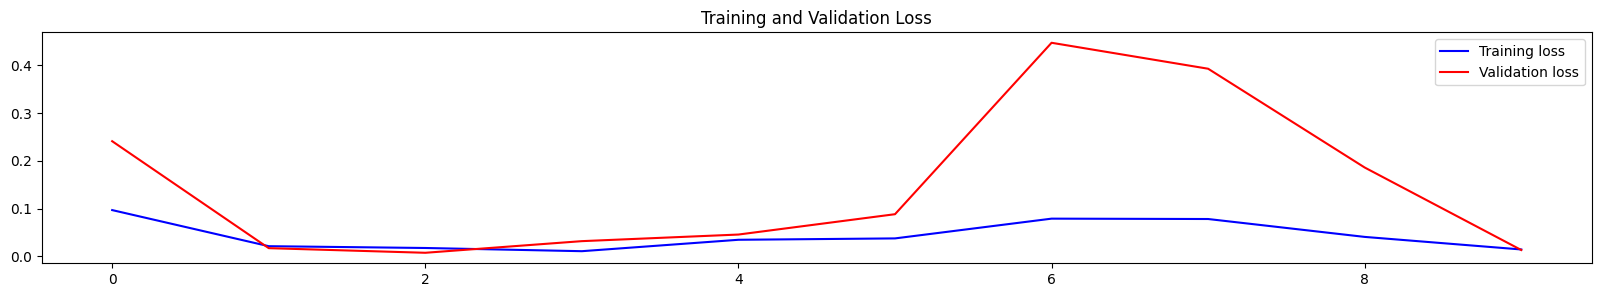

-------------------------------------------------- RESULTS --------------------------------------------------
7/7 [==============================] - 1s 55ms/step


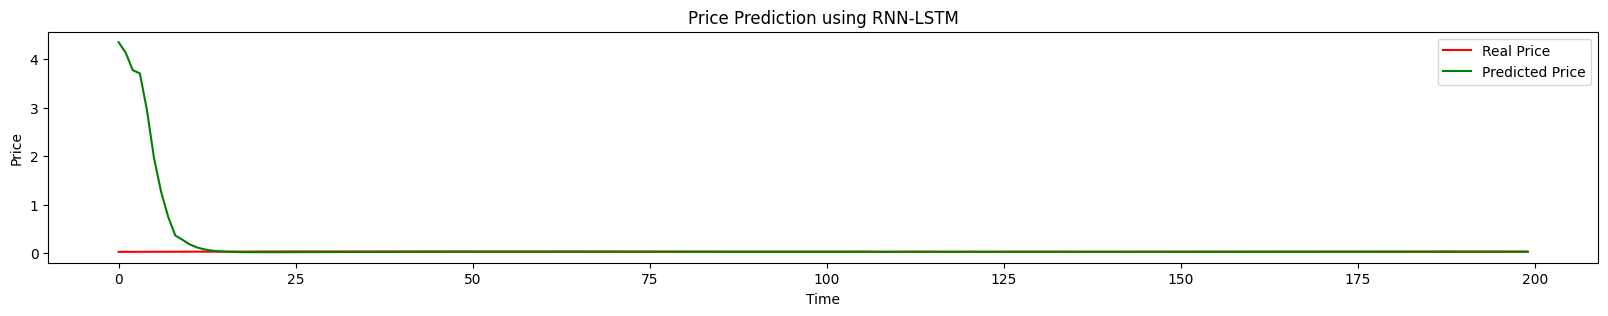

Total Directional Accuracy: 0.45%
Directional Accuracy of small moves: 0.42%
Directional Accuracy of large moves: 0.42%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1600
Size of test Data:
 400
Training Data Shape before sliding Window:
 1600
Training Data Shape with Sliding Window:
 (1540, 60, 5)
Test Data Shape with sliding Window:
 (400, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 60, 100)           42400     
                                                                 
 dropout_28 (Dropout)        (None, 60, 100)           0     

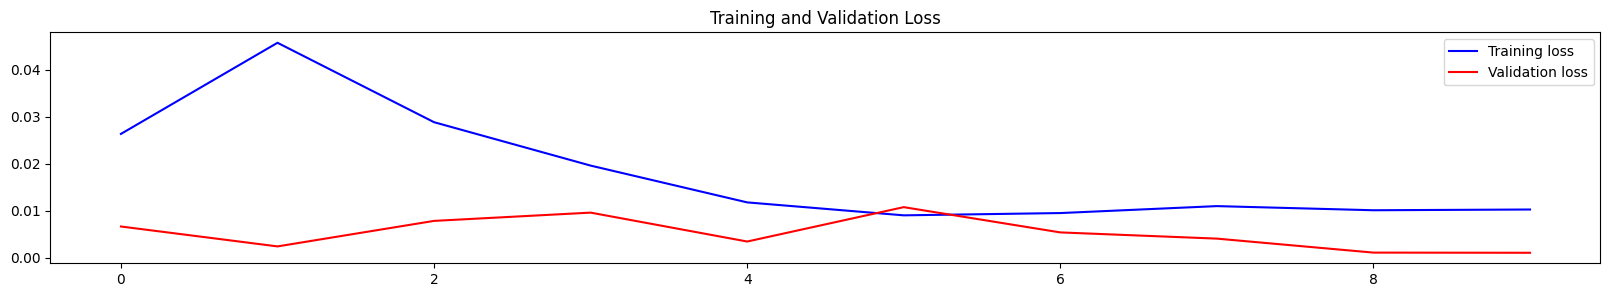

-------------------------------------------------- RESULTS --------------------------------------------------
13/13 [==============================] - 1s 57ms/step


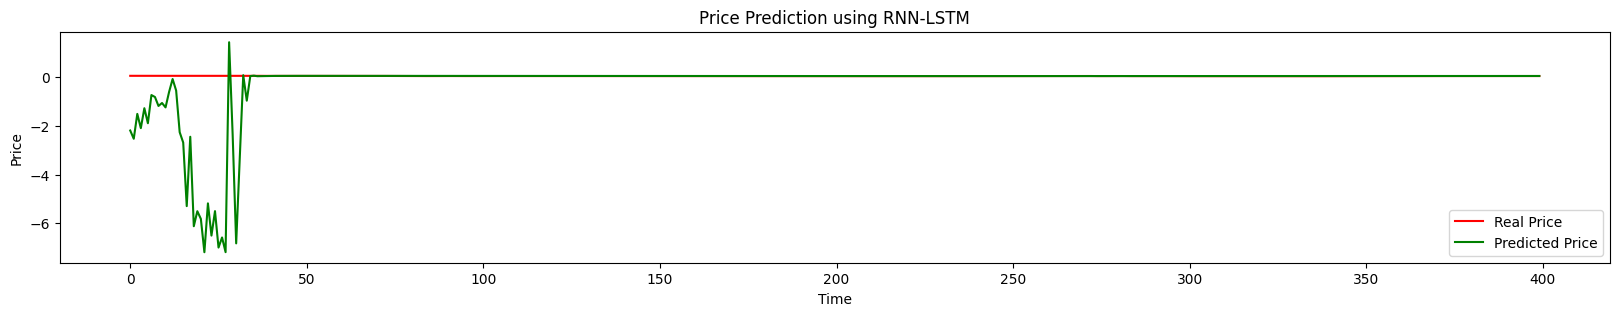

Total Directional Accuracy: 0.53%
Directional Accuracy of small moves: 0.55%
Directional Accuracy of large moves: 0.47%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 4000
Size of test Data:
 1000
Training Data Shape before sliding Window:
 4000
Training Data Shape with Sliding Window:
 (3940, 60, 5)
Test Data Shape with sliding Window:
 (1000, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 60, 100)           42400     
                                                                 
 dropout_32 (Dropout)        (None, 60, 100)           0   

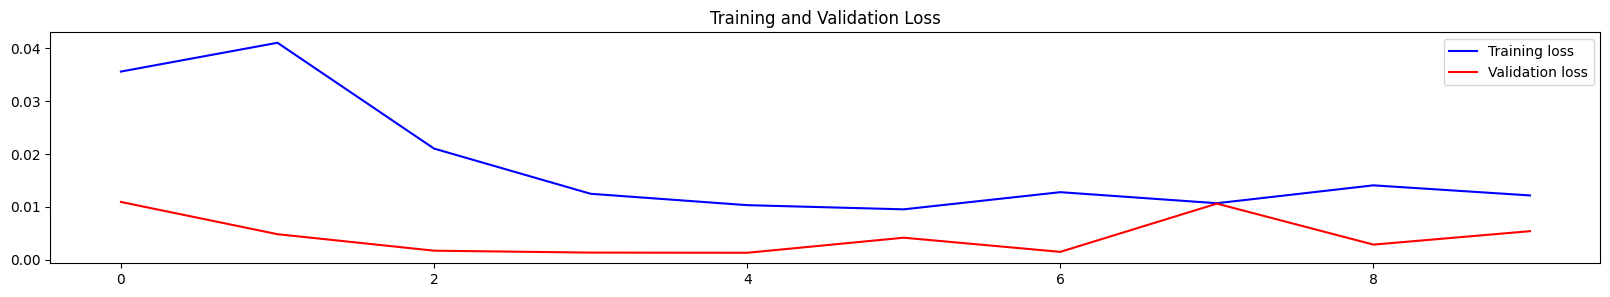

-------------------------------------------------- RESULTS --------------------------------------------------
32/32 [==============================] - 2s 58ms/step


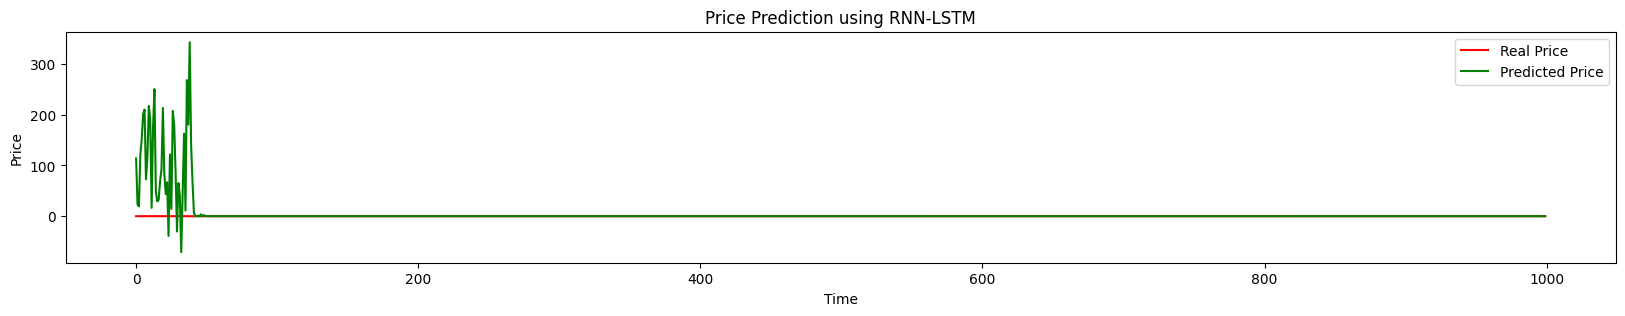

Total Directional Accuracy: 0.47%
Directional Accuracy of small moves: 0.47%
Directional Accuracy of large moves: 0.43%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 8000
Size of test Data:
 2000
Training Data Shape before sliding Window:
 8000
Training Data Shape with Sliding Window:
 (7940, 60, 5)
Test Data Shape with sliding Window:
 (2000, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 60, 100)           42400     
                                                                 
 dropout_36 (Dropout)        (None, 60, 100)           0   

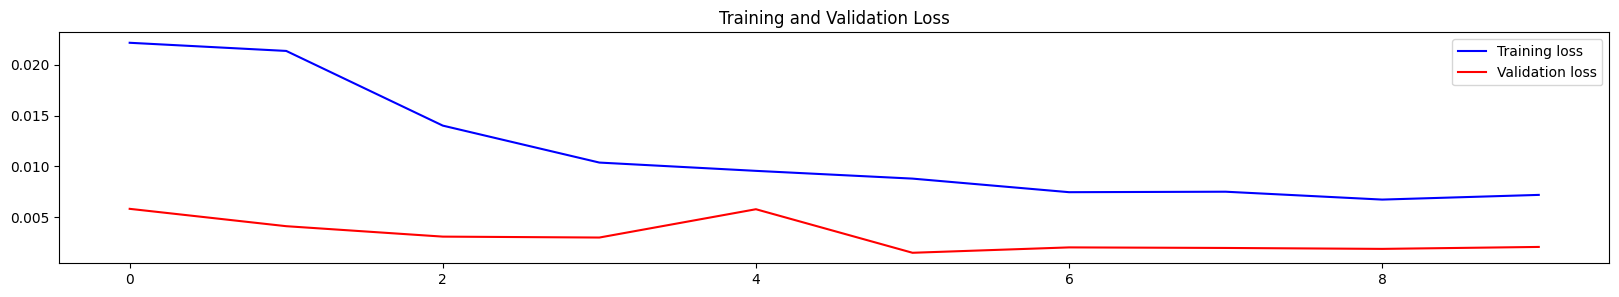

-------------------------------------------------- RESULTS --------------------------------------------------
63/63 [==============================] - 4s 58ms/step


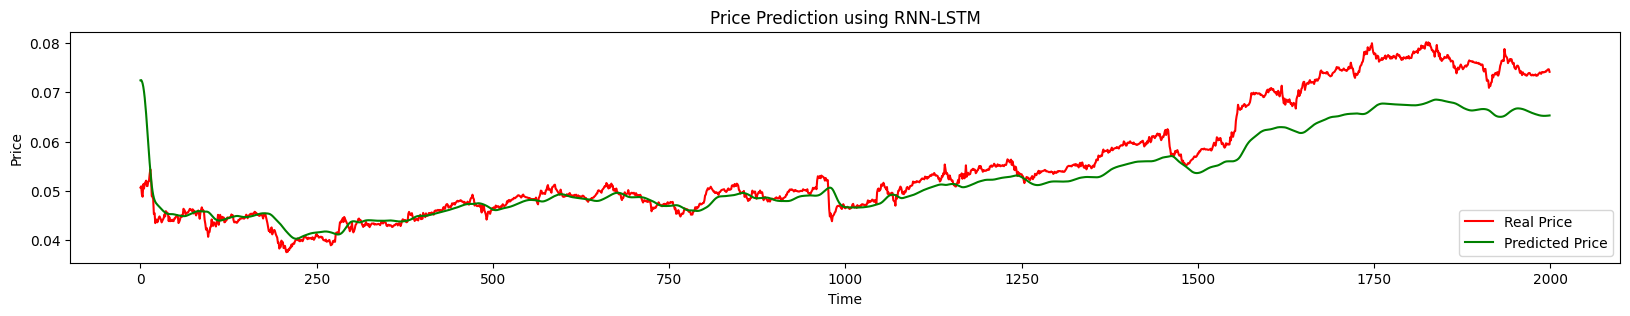

Total Directional Accuracy: 0.49%
Directional Accuracy of small moves: 0.50%
Directional Accuracy of large moves: 0.47%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 40000
Size of test Data:
 10000
Training Data Shape before sliding Window:
 40000
Training Data Shape with Sliding Window:
 (39940, 60, 5)
Test Data Shape with sliding Window:
 (10000, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 60, 100)           42400     
                                                                 
 dropout_40 (Dropout)        (None, 60, 100)         

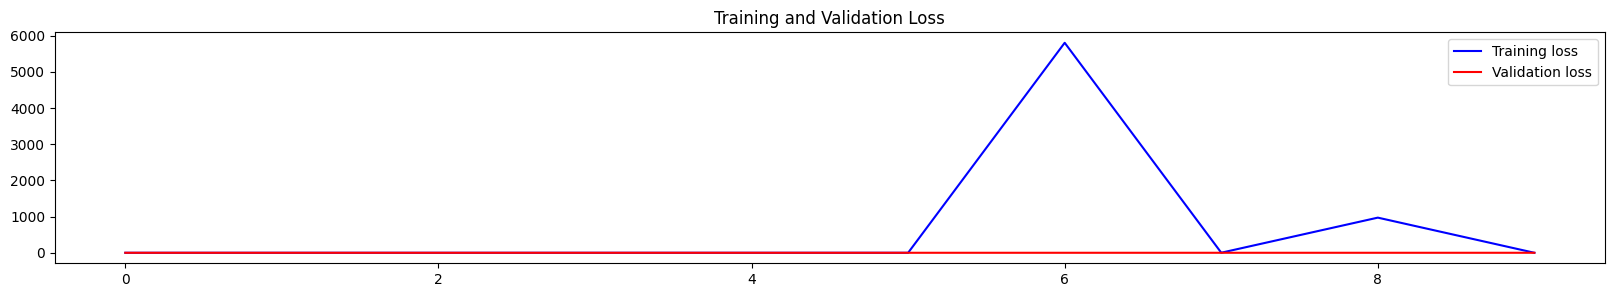

-------------------------------------------------- RESULTS --------------------------------------------------
313/313 [==============================] - 18s 57ms/step


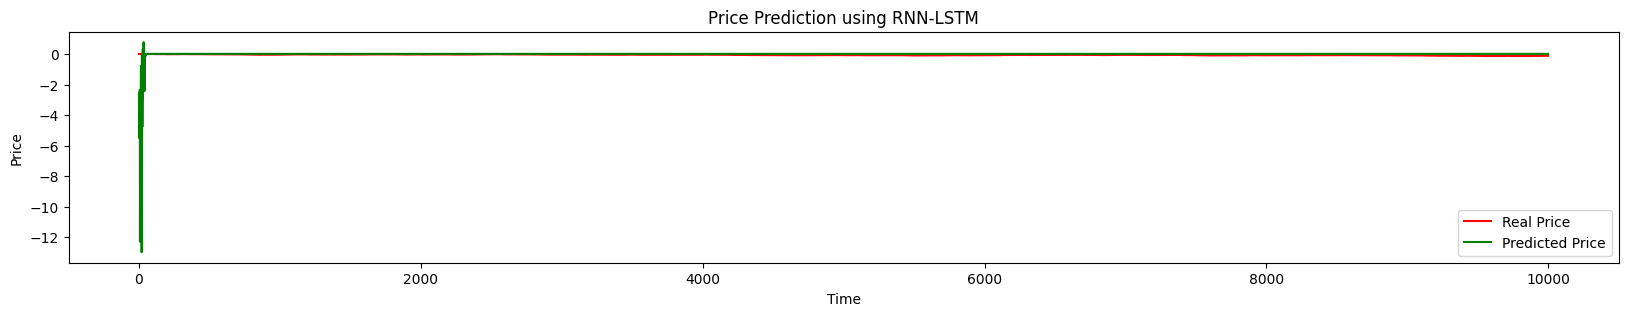

Total Directional Accuracy: 0.51%
Directional Accuracy of small moves: 0.51%
Directional Accuracy of large moves: 0.49%


In [4]:
window_size = 60
epochs = 10
batch_size =100
validation_split=0.1
train_test_split = 0.8
data_set_size = 2000
features = False
learning_rate = 0.01

path = 'results/results_{}.csv'.format("dataset_size")
res = pd.DataFrame(columns=['window_size', 'epochs', 'batch_size', 'validation_split', 'train_test_split', 'data_set_size', 'features',\
       'total_directional_accuracy', 'directional_accuracy_of_small_moves', 'directional_accuracy_of_large_moves'])
res.to_csv(path, index=False)

for data_set_size in [1000,2000,5000,10000,50000]:
    test_parameters(window_size, epochs, batch_size, validation_split,train_test_split, data_set_size, features, learning_rate, path)

# Learning Rate

-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1600
Size of test Data:
 400
Training Data Shape before sliding Window:
 1600
Training Data Shape with Sliding Window:
 (1540, 60, 5)
Test Data Shape with sliding Window:
 (400, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 60, 100)           42400     
                                                                 
 dropout_76 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_77 (LSTM)              (None, 60, 60)     

-------------------------------------------------- TRAINING STAGE --------------------------------------------------
Epoch 1/10
14/14 [==============================] - 10s 416ms/step - loss: 0.0191 - val_loss: 0.1089
Epoch 2/10
14/14 [==============================] - 5s 358ms/step - loss: 0.0507 - val_loss: 0.0288
Epoch 3/10
14/14 [==============================] - 5s 358ms/step - loss: 0.0575 - val_loss: 0.0042
Epoch 4/10
14/14 [==============================] - 5s 356ms/step - loss: 0.0552 - val_loss: 0.0336
Epoch 5/10
14/14 [==============================] - 5s 360ms/step - loss: 0.0203 - val_loss: 0.0613
Epoch 6/10
14/14 [==============================] - 5s 355ms/step - loss: 0.0154 - val_loss: 0.0016
Epoch 7/10
14/14 [==============================] - 5s 365ms/step - loss: 0.0109 - val_loss: 0.0029
Epoch 8/10
14/14 [==============================] - 5s 355ms/step - loss: 0.0109 - val_loss: 0.0089
Epoch 9/10
14/14 [==============================] - 5s 361ms/step - loss: 0.0078 -

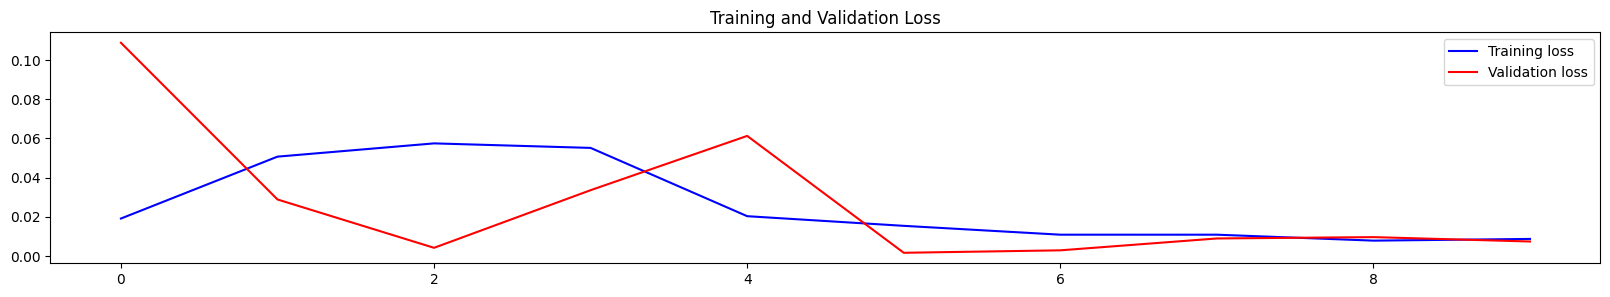

-------------------------------------------------- RESULTS --------------------------------------------------
13/13 [==============================] - 1s 60ms/step


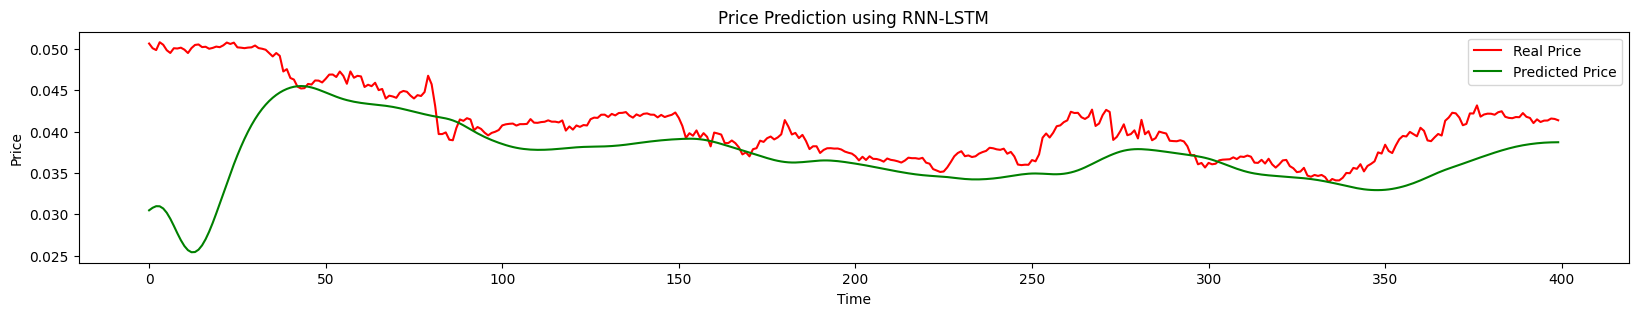

Total Directional Accuracy: 0.51%
Directional Accuracy of small moves: 0.50%
Directional Accuracy of large moves: 0.44%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1600
Size of test Data:
 400
Training Data Shape before sliding Window:
 1600
Training Data Shape with Sliding Window:
 (1540, 60, 5)
Test Data Shape with sliding Window:
 (400, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_80 (LSTM)              (None, 60, 100)           42400     
                                                                 
 dropout_80 (Dropout)        (None, 60, 100)           0    

-------------------------------------------------- TRAINING STAGE --------------------------------------------------
Epoch 1/10
14/14 [==============================] - 9s 373ms/step - loss: 0.0293 - val_loss: 0.0070
Epoch 2/10
14/14 [==============================] - 5s 341ms/step - loss: 0.0480 - val_loss: 0.0028
Epoch 3/10
14/14 [==============================] - 5s 336ms/step - loss: 0.0326 - val_loss: 0.0300
Epoch 4/10
14/14 [==============================] - 5s 335ms/step - loss: 0.0185 - val_loss: 0.0033
Epoch 5/10
14/14 [==============================] - 5s 332ms/step - loss: 0.0099 - val_loss: 0.0070
Epoch 6/10
14/14 [==============================] - 5s 334ms/step - loss: 0.0096 - val_loss: 0.0230
Epoch 7/10
14/14 [==============================] - 5s 333ms/step - loss: 0.0096 - val_loss: 0.0224
Epoch 8/10
14/14 [==============================] - 5s 336ms/step - loss: 0.0113 - val_loss: 0.0066
Epoch 9/10
14/14 [==============================] - 5s 333ms/step - loss: 0.0179 - 

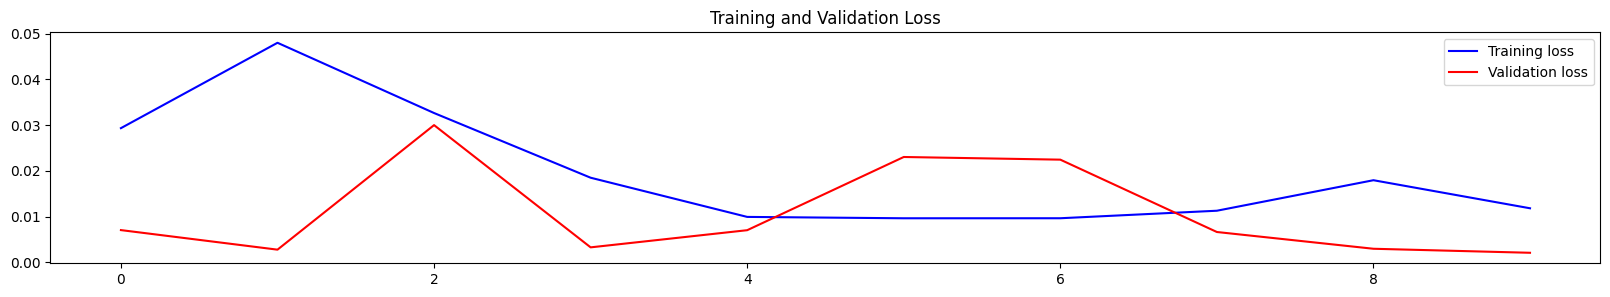

-------------------------------------------------- RESULTS --------------------------------------------------
13/13 [==============================] - 1s 57ms/step


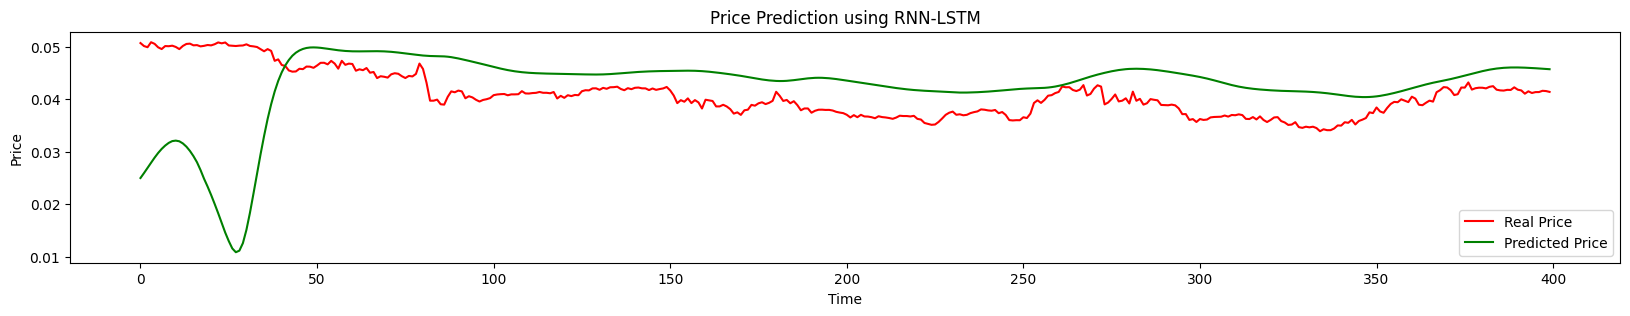

Total Directional Accuracy: 0.52%
Directional Accuracy of small moves: 0.59%
Directional Accuracy of large moves: 0.43%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1600
Size of test Data:
 400
Training Data Shape before sliding Window:
 1600
Training Data Shape with Sliding Window:
 (1540, 60, 5)
Test Data Shape with sliding Window:
 (400, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_84 (LSTM)              (None, 60, 100)           42400     
                                                                 
 dropout_84 (Dropout)        (None, 60, 100)           0    

-------------------------------------------------- TRAINING STAGE --------------------------------------------------
Epoch 1/10
14/14 [==============================] - 10s 379ms/step - loss: 0.0623 - val_loss: 0.2448
Epoch 2/10
14/14 [==============================] - 5s 335ms/step - loss: 0.0590 - val_loss: 0.0061
Epoch 3/10
14/14 [==============================] - 5s 336ms/step - loss: 0.0568 - val_loss: 0.0366
Epoch 4/10
14/14 [==============================] - 5s 332ms/step - loss: 0.0167 - val_loss: 0.0089
Epoch 5/10
14/14 [==============================] - 5s 332ms/step - loss: 0.0134 - val_loss: 0.0108
Epoch 6/10
14/14 [==============================] - 5s 330ms/step - loss: 0.0128 - val_loss: 0.0023
Epoch 7/10
14/14 [==============================] - 5s 331ms/step - loss: 0.0104 - val_loss: 0.0022
Epoch 8/10
14/14 [==============================] - 5s 331ms/step - loss: 0.0088 - val_loss: 0.0057
Epoch 9/10
14/14 [==============================] - 5s 334ms/step - loss: 0.0083 -

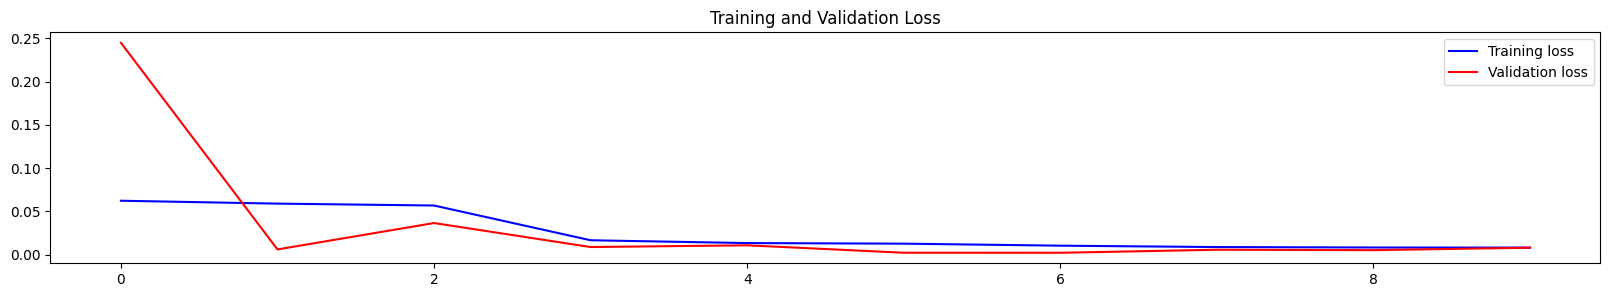

-------------------------------------------------- RESULTS --------------------------------------------------
13/13 [==============================] - 1s 57ms/step


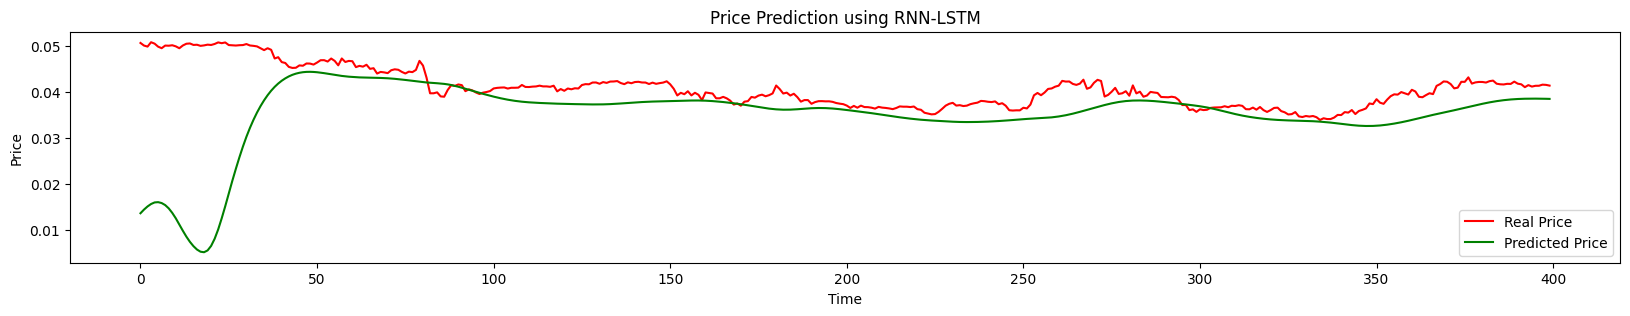

Total Directional Accuracy: 0.51%
Directional Accuracy of small moves: 0.51%
Directional Accuracy of large moves: 0.44%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1600
Size of test Data:
 400
Training Data Shape before sliding Window:
 1600
Training Data Shape with Sliding Window:
 (1540, 60, 5)
Test Data Shape with sliding Window:
 (400, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_88 (LSTM)              (None, 60, 100)           42400     
                                                                 
 dropout_88 (Dropout)        (None, 60, 100)           0    

-------------------------------------------------- TRAINING STAGE --------------------------------------------------
Epoch 1/10
14/14 [==============================] - 9s 370ms/step - loss: 0.0593 - val_loss: 0.1520
Epoch 2/10
14/14 [==============================] - 5s 334ms/step - loss: 0.0151 - val_loss: 0.0131
Epoch 3/10
14/14 [==============================] - 5s 330ms/step - loss: 0.0248 - val_loss: 0.0097
Epoch 4/10
14/14 [==============================] - 5s 330ms/step - loss: 0.0199 - val_loss: 0.0026
Epoch 5/10
14/14 [==============================] - 5s 338ms/step - loss: 0.0123 - val_loss: 0.0046
Epoch 6/10
14/14 [==============================] - 5s 338ms/step - loss: 0.0133 - val_loss: 0.0221
Epoch 7/10
14/14 [==============================] - 5s 333ms/step - loss: 0.0117 - val_loss: 0.0222
Epoch 8/10
14/14 [==============================] - 5s 333ms/step - loss: 0.0095 - val_loss: 0.0232
Epoch 9/10
14/14 [==============================] - 5s 330ms/step - loss: 0.0109 - 

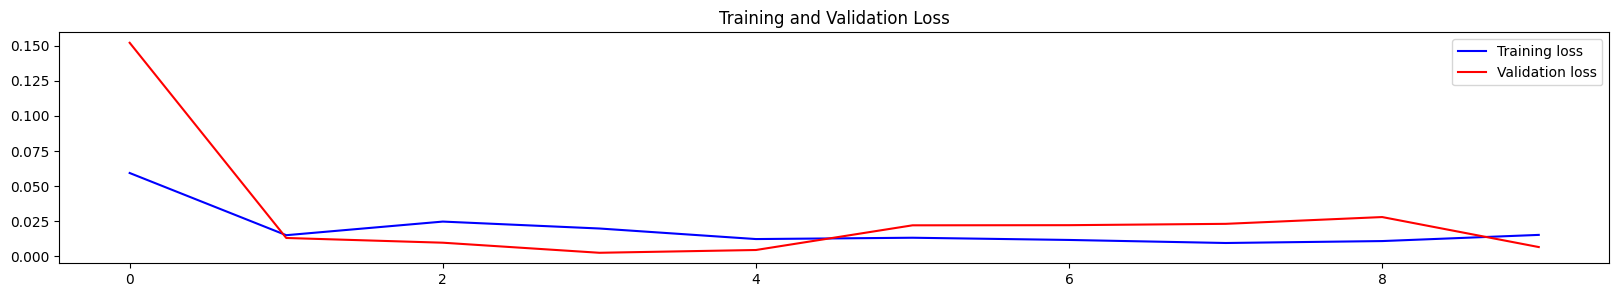

-------------------------------------------------- RESULTS --------------------------------------------------
13/13 [==============================] - 1s 57ms/step


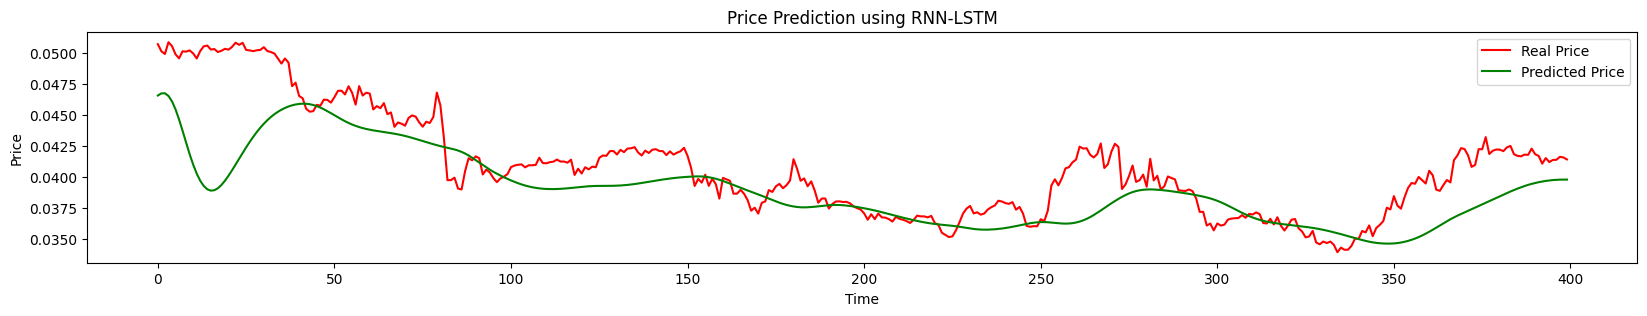

Total Directional Accuracy: 0.51%
Directional Accuracy of small moves: 0.50%
Directional Accuracy of large moves: 0.46%
-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1600
Size of test Data:
 400
Training Data Shape before sliding Window:
 1600
Training Data Shape with Sliding Window:
 (1540, 60, 5)
Test Data Shape with sliding Window:
 (400, 60, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_92 (LSTM)              (None, 60, 100)           42400     
                                                                 
 dropout_92 (Dropout)        (None, 60, 100)           0    

-------------------------------------------------- TRAINING STAGE --------------------------------------------------
Epoch 1/10
14/14 [==============================] - 11s 379ms/step - loss: 0.0442 - val_loss: 0.1066
Epoch 2/10
14/14 [==============================] - 5s 329ms/step - loss: 0.0531 - val_loss: 0.0429
Epoch 3/10
14/14 [==============================] - 5s 339ms/step - loss: 0.0525 - val_loss: 0.0254
Epoch 4/10
14/14 [==============================] - 5s 330ms/step - loss: 0.0288 - val_loss: 0.0035
Epoch 5/10
14/14 [==============================] - 5s 333ms/step - loss: 0.0335 - val_loss: 0.0820
Epoch 6/10
14/14 [==============================] - 5s 338ms/step - loss: 0.0173 - val_loss: 0.0408
Epoch 7/10
14/14 [==============================] - 5s 334ms/step - loss: 0.0298 - val_loss: 0.0171
Epoch 8/10
14/14 [==============================] - 5s 332ms/step - loss: 0.0339 - val_loss: 0.0321
Epoch 9/10
14/14 [==============================] - 5s 332ms/step - loss: 0.0112 -

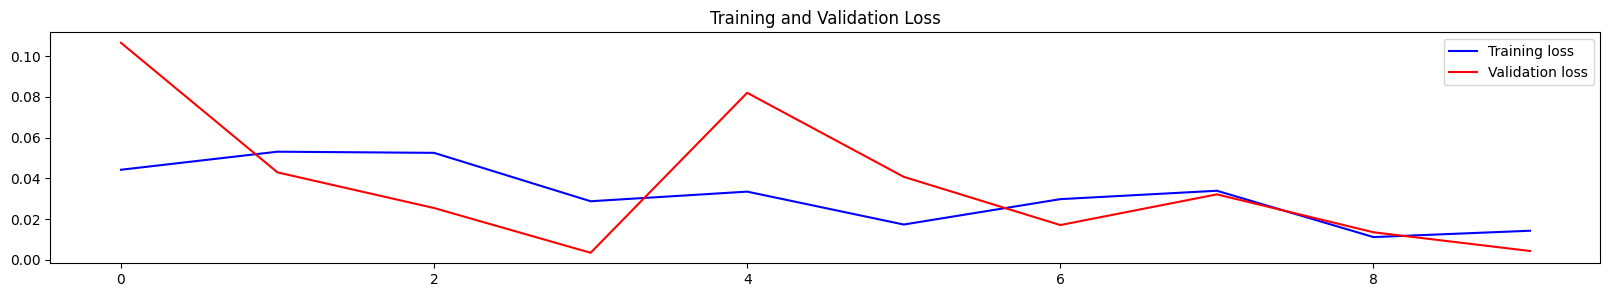

-------------------------------------------------- RESULTS --------------------------------------------------
13/13 [==============================] - 1s 57ms/step


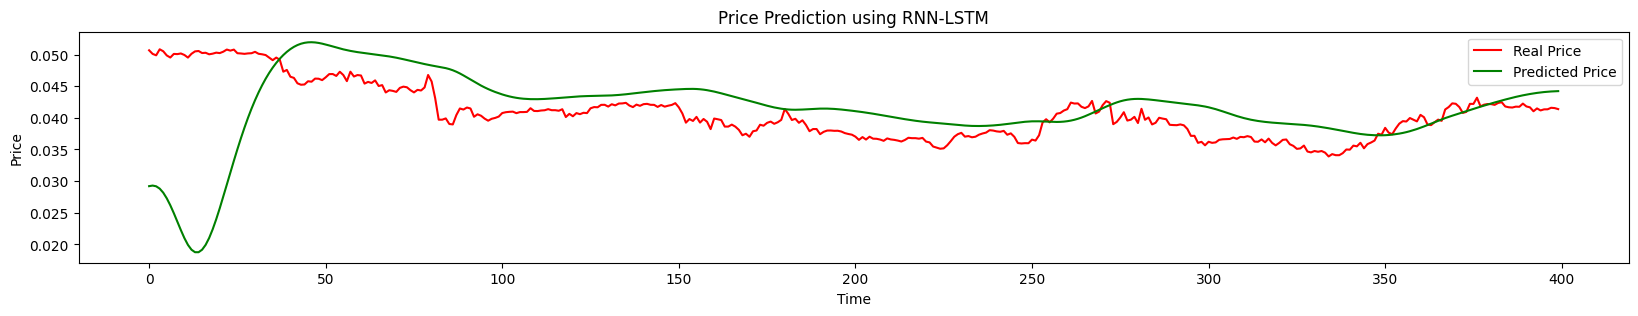

Total Directional Accuracy: 0.50%
Directional Accuracy of small moves: 0.43%
Directional Accuracy of large moves: 0.46%


In [19]:
window_size = 60
epochs = 10
batch_size =100
validation_split=0.1
train_test_split = 0.8
data_set_size = 2000
features = False
learning_rate = 0.01

path = 'results/results_{}.csv'.format("learning_rate")
res = pd.DataFrame(columns=['window_size', 'epochs', 'batch_size', 'validation_split', 'train_test_split', 'data_set_size', 'features',\
       'learning_rate','total_directional_accuracy', 'directional_accuracy_of_small_moves', 'directional_accuracy_of_large_moves'])
res.to_csv(path, index=False)

for learning_rate in [0.1, 0.05, 0.01, 0.005, 0.001]:
    test_parameters(window_size, epochs, batch_size, validation_split,train_test_split, data_set_size, features, learning_rate, path)

# Final Model

-------------------------------------------------- DATA PROCESSING --------------------------------------------------
Features:
 Index(['close', 'open', 'high', 'low', 'tick_volume'], dtype='object')
Size of Training Data :
 1710
Size of test Data:
 190
Training Data Shape before sliding Window:
 1710
Training Data Shape with Sliding Window:
 (1705, 5, 5)
Test Data Shape with sliding Window:
 (190, 5, 5)
-------------------------------------------------- MODEL INITIALIZATION --------------------------------------------------
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_96 (LSTM)              (None, 5, 100)            42400     
                                                                 
 dropout_96 (Dropout)        (None, 5, 100)            0         
                                                                 
 lstm_97 (LSTM)              (None, 5, 5)         

-------------------------------------------------- TRAINING STAGE --------------------------------------------------
Epoch 1/10
8/8 [==============================] - 5s 120ms/step - loss: 0.2881 - val_loss: 0.6038
Epoch 2/10
8/8 [==============================] - 0s 46ms/step - loss: 0.1432 - val_loss: 0.2131
Epoch 3/10
8/8 [==============================] - 0s 47ms/step - loss: 0.0365 - val_loss: 0.0023
Epoch 4/10
8/8 [==============================] - 0s 47ms/step - loss: 0.0991 - val_loss: 0.0480
Epoch 5/10
8/8 [==============================] - 0s 46ms/step - loss: 0.0534 - val_loss: 0.0273
Epoch 6/10
8/8 [==============================] - 0s 47ms/step - loss: 0.0337 - val_loss: 0.0150
Epoch 7/10
8/8 [==============================] - 0s 47ms/step - loss: 0.0439 - val_loss: 0.0393
Epoch 8/10
8/8 [==============================] - 0s 46ms/step - loss: 0.0249 - val_loss: 0.0071
Epoch 9/10
8/8 [==============================] - 0s 46ms/step - loss: 0.0338 - val_loss: 0.0313
Epoch 10/

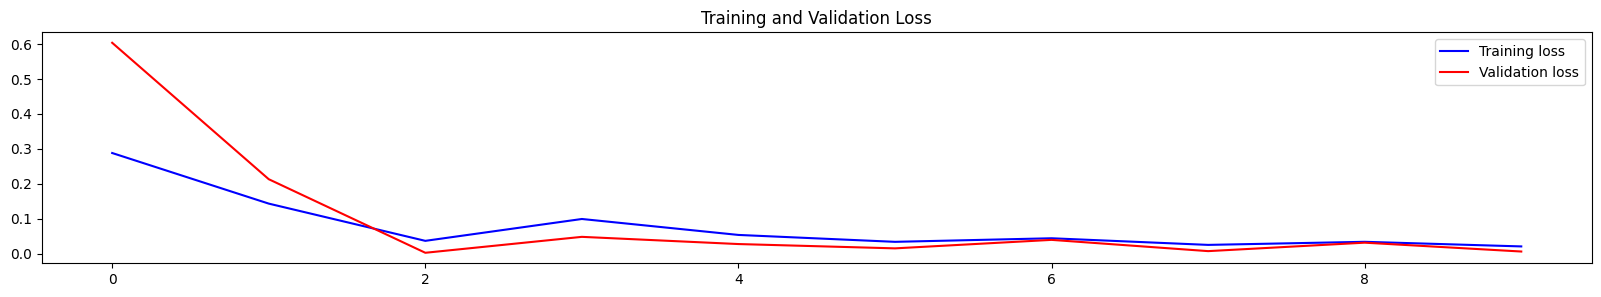

-------------------------------------------------- RESULTS --------------------------------------------------
6/6 [==============================] - 0s 7ms/step


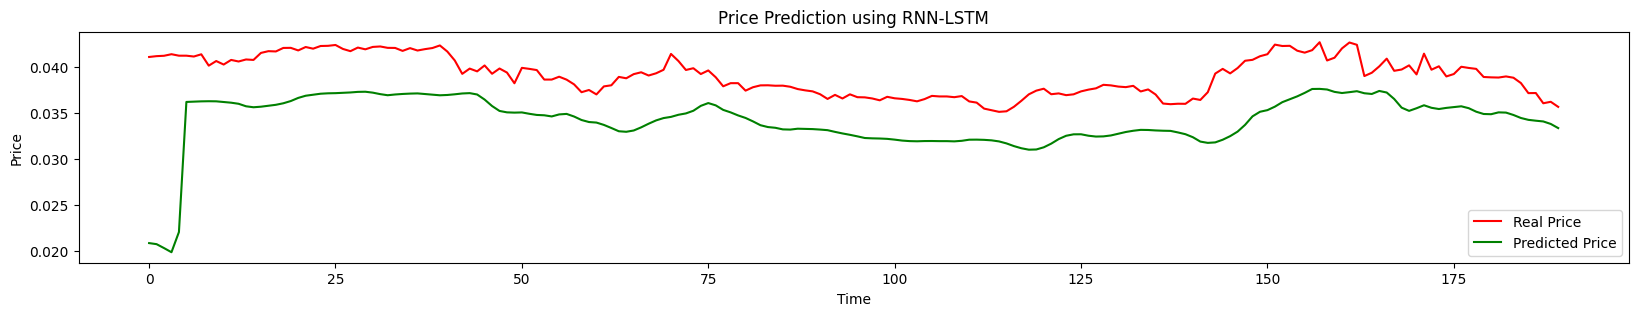

Total Directional Accuracy: 0.56%
Directional Accuracy of small moves: 0.66%
Directional Accuracy of large moves: 0.51%


In [20]:
window_size = 5
epochs = 10
batch_size =200
validation_split=0.1
train_test_split = 0.90
data_set_size = 1900
features = False
learning_rate = 0.05



test_parameters(window_size, epochs, batch_size, validation_split,train_test_split, data_set_size, features, learning_rate, path)